### ***Aprendizaje Por Refuerzo - Actividad Práctica***
#  **Implementación de un Agente para la Robótica Espacial**


#### Resolución del entorno Luna-Lander de la librería Gym de OpenAI utilizando técnicas de aprendizaje por refuerzo profundo.


Máster Oficial en Ciencia de Datos - UOC 
#### Jorge Álvarez Gracia  
*2022-2023*

# **Indice de Contenidos**

0. [Configuraciones Iniciales](#id1)

1. [Clases y Métodos Utilizados](#id2)

2. [Respuesta a los ejercicios](#id3)

      A. [Entorno](#id4)

      B. [Agente de Referencia](#id5)

      C. [Propuesta de Mejora](#id6)




# 0) Configuraciones Inciales <a name="id1"></a>

Instalamos e importamos las librerias necesarias. 


### Uso en Colab

In [ ]:
import sys
IS_COLAB = "google.colab" in sys.modules

import warnings
warnings.filterwarnings('ignore')

if IS_COLAB:  

  #Ejecutar esta celda sólo si ejecutamos este notebook en Google Colab desde Drive
  from google.colab import drive
  drive.mount('/content/drive')
  # MODIFICAR ACORDE A LA RUTA DE TUS CARPETAS
  %cd /content/drive/MyDrive/UOC_Master_DataScience/UOC_Aprendizaje_por_Refuerzo/PRAC
  !pip install gym[box2d]

Mounted at /content/drive
/content/drive/MyDrive/UOC_Master_DataScience/UOC_Aprendizaje_por_Refuerzo/PRAC
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it

### Librerias & Requirements

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Utils
import time
import numpy as np
import random
import math
import base64, io
from tqdm import tqdm
import os
import glob
import dill as pickle
from copy import deepcopy, copy
# Data
from collections import defaultdict
from collections import deque, namedtuple
from typing import Dict, List, Tuple
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize' :[ 10,8.27]}
sns.set_theme(style="ticks", palette= "Dark2" , rc=custom_params)

# gym rl
import gym

# pytorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

# Videos
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 

## Settings

In [ ]:
# Comprobación de la versión de GYM instalada
print('La versión de gym instala: ' + gym.__version__)
# Comprobación de entorno con gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("El entorno utiliza: ", device)

La versión de gym instala: 0.25.2
El entorno utiliza:  cpu


In [ ]:
ENV_NAME = "LunarLander-v2"
AGENT_NAME = 'DQN_agent'

switch_action = {
        0: "do nothing",
        1: "fire left orientation engine",
        2: "fire main engine",
        3: "fire right orientation engine",
    }

SEED = 1234

# Create Agent

MEMORY_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64
TARGET_UPDATE = 4
EPSILON_DECAY = 0.995
NN_UNITS = int(64)
GAMMA = 0.99  
TAU = 1e-3 
LR = 5e-4
MAX_EPSILON =  1.0
MIN_EPSILON = 0.01
THRESHOLD = 200
SEED = 123     
THRESHOLD = 200

ISNOISY = True
# Train
N_EPISODES = 2000
CONSECUTIVE_EIPOSDES = 100


# I) Clases y métodos utilizados <a name="id2"></a>

### Utils - Conocimiento Inicial del Entorno

In [ ]:
def env_analysis(env_name: str)-> Tuple[int, int]:

  """ Returns information about the chosen environment.

      Params
        ======
        env_name (str): environment name.

      Returns
        ======
        int: enviroment action space
        int: enviroment observation space
      
  """

  env = gym.make(env_name)
  name = env.unwrapped.spec.id

  print(f'[INFO]: {"-"*50} Initial analysis of the environment: [{name}] {"-"*50}\n')

  reward_range = env.reward_range 
  print(f'[INFO]: The Reward range is: {reward_range} ')

  max_episode_steps = env.spec.max_episode_steps
  print(f'[INFO]: The Max Episode Step is: {max_episode_steps} ')

  action_space = env.action_space.n
  print(f'[INFO]: The dimension of  action space is: {action_space})')

  observation_space = env.observation_space.shape
  print(f'[INFO]: The dimension of observation space is: {observation_space}')

  return action_space, observation_space[0]

In [ ]:
def env_initial_observation(env_name: str) -> None:

  """ Creates a initial enviroment observation.
  
      Params
        ======
        env_name (str): environment name.   
  """

  env = gym.make(env_name)
  obs = env.reset()

  env = gym.make(env_name)
  name = env.unwrapped.spec.id

  print(f'[INFO]: {"-"*50} Initial Observations of the environment: [{name}] {"-"*50}\n')

  observation_space = env.observation_space.shape

  for i, obs in zip(range(observation_space[0]), obs):
    print(f'[INFO]: Obs_{i}: {obs}')

In [ ]:
def random_agent(env_name: str, isPrint: bool = True) -> list:

  """ Generate an agent with a random policy.

      Params
        ======
        env_name (str): environment name.   
        isPrint (bool): print or no some information.

       
      Returns
        ======
        list: list with the total of rewards
  """

  t, total_reward, done = 0, 0, False

  env = gym.make(env_name)
  obs = env.reset()

  if isPrint: 
    print(f'[INFO]: {"-"*50} Random Action Agent {"-"*50}\n')

  while not done:
    
    # Elegir una acción aleatoria
    action = env.action_space.sample()
    
    # Ejecutar la acción y esperar la respuesta del entorno
    new_obs, reward, done, info,  = env.step(action)
    
    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1

  if isPrint:  
    print(f"[INFO]: Episode ended after {t} steps and reward was {total_reward} ")

  env.close()

  return total_reward

In [ ]:
def play_game(env_name: str, episodes: int)-> Tuple[list, list] :


  """ Use of the environment a certain number of episodes.

      Params
        ======
        env_name (str): environment name.   
        episodes (int): number of episodes.

       
      Returns
        ======
        list: list the total of rewards for the episode.
        steps_episode: list the total of steps for the episode.
  """

  env = gym.make(env_name)
  steps_episode = []
  
  total_rewards = []
  steps_episode = []

  for _ in tqdm(range(episodes)):
    done = False
    env.reset()
    steps = 0
    rewards = 0
    while not done:
          action = env.action_space.sample()
          state, reward, done, _ = env.step(action)
          rewards += reward
          steps += 1

    total_rewards.append(rewards)

    steps_episode.append(steps)
  
  return  steps_episode, total_rewards

In [ ]:
def plot_histograms(histogram_name: str, total_rewards: List[int] ,steps_episode: List[int]) -> None:

    """ Plot and save total rewards and steps episode histograms.

      Params
        ======
        total_rewards (str): list the total of rewards for the episode. 
        steps_episode (int): list the total of steps for the episode.

    """

    os.makedirs('Images', exist_ok = True)

    df_total_rewards= pd.DataFrame(total_rewards , columns=["total_rewards"])
    df_steps_episode = pd.DataFrame(steps_episode , columns=["steps_episode"])

    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    fig.suptitle('Total Rewars & Episode Density')

    sns.histplot(ax=axes[0],
                data=df_total_rewards, 
                x="total_rewards", 
                kde=True, 
                stat = 'density',
                bins=30).set(title='Total Rewards Density')
    sns.histplot(ax=axes[1], data=df_steps_episode, 
                x="steps_episode", 
                kde=True, 
                stat = 'density', color='red',
                bins=30).set(title='Total Steps by Episode Density' )
    plt.savefig(f'Images/histogram_{histogram_name}.png')
    plt.show()

### Utils - Create and show Video

Estas funciones han sido obtenidas y modificadas del siguiente repositorio de github: [Más información](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html)


In [ ]:
def show_video(env_name: str, video_name: str) -> None:

    """ Shows a video created previously.

        Params
          ======
          env_name (str): environment name.   
          video_name (int): video name.

    """

    mp4list = glob.glob('Videos/*.mp4')

    if len(mp4list) > 0:
        mp4 = f'Videos/{video_name}.mp4'
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("[INFO]: Could not find video")    

In [ ]:
def create_show_video_of_the_agent(env_name: str, 
                               video_name: str,
                               agent = None,
                               isRandom = False) -> None:

    """ Create and save video of the game given an agent.

        Params
          ======
          env_name (str): environment name.   
          video_name (int): video name.
          agent (DQN Agent): DQN Agent Trained.

    """                           

    os.makedirs('Videos', exist_ok = True)
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path=f'Videos/{video_name}.mp4')
    #agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        # random action
        if isRandom:
          action =  env.action_space.sample()

        else: 
          action = agent.select_action(state)
        
        state, reward, done, _ = env.step(action)

    env.close()

### Utils - Find best Agent

In [ ]:
def find_best_agent(batch_size_list: List[int], lr_list: List[float],
                    gamma_list: List[float], csv_name: str, 
                    isFinal_model = False) -> pd.DataFrame: 

  """ Use of the environment a certain number of episodes.

      Params:
        ======
        batch_size_list (list): list of batchs to hyperparameterize.
        lr_list (int): list of learning rates to hyperparameterize.
        gamma_list (list): list of discount rates to hyperparameterize.
        csv_name (str): name of the csv.
        isFinal_model (bool): tells us if it is an agent or another.
       
      Returns:
        ======
        data: pandas dataframe with hyperparameters obtained of the differents trained agents.
        
  """

  info_dict = {'agent_name':[], 'batch_size':[], 'lr':[], 'gamma':[], 'reward_mean':[],
               'reward_std':[], 'training_time':[], 'solved_episode':[],
              }

  path_trained_agents = 'Models'
  os.makedirs(path_trained_agents, exist_ok=True)     

  t = 1
  for batch_size in batch_size_list:
    for lr in lr_list:
       for gamma in gamma_list:

          if isFinal_model: 
          
            agent_name = f'{t}_DDQN_Agent'  # En el futuro crear a un nombre en las configuraciones

          else:

            agent_name = f'{t}_DQN_Agent'


          agent = DQNAgent(ENV_NAME, agent_name, MEMORY_SIZE,batch_size,
                           TARGET_UPDATE, EPSILON_DECAY,TAU, ISNOISY, NN_UNITS,
                           gamma, lr, MAX_EPSILON, MIN_EPSILON,THRESHOLD, SEED
                           )
  

          print(f'\n[INFO]: {"-"*20} AGENT {t} Hyperparameters {"-"*20}\n')
          print(f'[INFO]: Batch Size: [{agent.batch_size}')
          print(f'[INFO]: Learning Rate: [{agent.lr}]')
          print(f'[INFO]: Gamma: [{agent.gamma}]\n')

          
          reward_mean, training_time,  solved_episode =  agent.train(EPISODES)
          

          info_dict['agent_name'].append(agent_name)
          info_dict['batch_size'].append(batch_size)
          info_dict['lr'].append(lr)
          info_dict['gamma'].append(gamma)
          info_dict['reward_mean'].append(reward_mean)
          info_dict['reward_std'].append(np.std(agent.training_rewards))
          info_dict['training_time'].append(training_time)
          info_dict['solved_episode'].append(solved_episode)
          

          t +=1                  

  data = pd.DataFrame.from_dict(info_dict)  

  path_trained_agents = 'Models'
  os.makedirs(path_trained_agents, exist_ok=True)
  data.to_csv( os.path.join(path_trained_agents,csv_name))
                            
  return data


### Utils -Load Model

In [ ]:
def load_agent_weights(agent, agent_dir_name: str):

  """ Load agent weigths from saved folder.

      Params:
        ======
        agent (agent): DQN Agent
        agent_dir_name (str): agent_dir_name
        
      Returns:
        ======
        DQNAgent: trained agent.
  """
  path_trained_agents = 'Models'
  
  return agent.dqn.load_state_dict(torch.load(os.path.join(path_trained_agents, 
                                                           agent_dir_name)))

### Utils - Compare results

In [ ]:
def plot_compare_results(mean_training_rewards_m1 : List[float], 
                         mean_training_rewards_m2  : List[float],
                         max_episodes: int, reward_threshold: int)-> None: 
  

    """ Plot differents models metrics for comparations.

      Params:
        ======
        mean_training_rewards_m1 (list): list of model 1 mean training rewards 
        mean_training_rewards_m2 (list): list of model 2 mean training rewards 
        max_episodes (int): numner of episodes 
        reward_threshold (int): predefined reward threshold

    """

    df_AgentDQN= pd.DataFrame(mean_training_rewards_m1 , columns=["AgentDQN"])
    df_Agent_Dueling_DQN = pd.DataFrame(mean_training_rewards_m2 , columns=["Agent_Dueling_&_Noisy_DQN"])
 
    df_threshold = pd.DataFrame(np.full((max_episodes,1), reward_threshold, dtype=int), columns =["threshold"] )


    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    fig.suptitle('Total Rewards & Loss by Training Episode')
      
    sns.lineplot(data=df_AgentDQN, 
                  x= df_AgentDQN.index , y ="AgentDQN", 
                  label="Agent DQN", linestyle="-"
                  ).set(title='Total Rewards')

    sns.lineplot(data=df_Agent_Dueling_DQN, x= df_Agent_Dueling_DQN.index ,
                  y="Agent_Dueling_&_Noisy_DQN", color='red', label="Agent_Dueling_&_Noisy_DQN", linestyle="dashdot")
    

    sns.lineplot(data=df_threshold, x= df_threshold.index ,
                  y="threshold", color='darkblue', label="Threshold", linestyle="--")           

    plt.savefig(f'Images/Final_Results.png')
    plt.show()

### NN DQN 

Red neuronal simple para el primer modelo.

In [ ]:
class NN(nn.Module):

    """Linear Neural Network.
    
     Attributes:
        in_dim (int): output size of neural network
        out_dim (int): output size of neural network
        seed (int): seed of neural network
        units (int): units of the neural network
        
    """

    def __init__(self, in_dim: int, out_dim: int, seed:int, units : int = 64):
        """Initialization."""
        super(NN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layers = nn.Sequential(
            nn.Linear(in_dim, units), 
            nn.ReLU(),
            nn.Linear(units, units), 
            nn.ReLU(), 
            nn.Linear(units, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

### Noisy Layer

Esta clase de la capa Noisy han sido obtenida de los siguientes repositorios de github: 

*Más información*: [[1]](https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb)
[[2]](https://github.com/Kaixhin/Rainbow/blob/master/model.py)

In [ ]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

### NN Dueling + Noisy 

In [ ]:
class NN(nn.Module):

    """Dueling + Noisy Neural Network.
    
     Attributes:
        in_dim (int): output size of neural network
        out_dim (int): output size of neural network
        seed (int): seed of neural network
        units (int): units of the neural network
        
    """

    def __init__(self, in_dim: int, out_dim: int, seed:int, units : int = 64):
        """Initialization."""
        super(NN, self).__init__()
        
        self.n_actions = out_dim
        self.seed = torch.manual_seed(seed)
  
        self.fc1 = nn.Linear(in_dim, units)
        self.fc2 = nn.Linear(units, units) 
        # calculate V(s)
        self.fc3_1 = NoisyLinear(units, units)
        self.fc4_1 = NoisyLinear(units, 1)
        # calculate A(s,a)
        self.fc3_2 = NoisyLinear(units, units)
        self.fc4_2 = NoisyLinear(units, out_dim)

    def forward(self, state):
        """Forward method implementation."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        val = F.relu(self.fc3_1(x))
        val = self.fc4_1(val)

        adv = F.relu(self.fc3_2(x))
        adv = self.fc4_2(adv)

        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        action = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.n_actions)
        return action

    def reset_noise(self):
        """Reset all noisy layers."""
        self.fc3_1.reset_noise()
        self.fc3_2.reset_noise()
        self.fc4_1.reset_noise()
        self.fc4_2.reset_noise()

### Replay Buffer 
Esta clase han sido obtenida del siguiente repositorio de github: [Más información](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html)

[Paper](https://arxiv.org/pdf/1706.10295.pdfl)


In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent DQN

In [103]:
class DQNAgent:
    """DQN Agent 
    
    """

    def __init__(
        self, 
        env_name: str, 
        agent_name: str,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        tau: float,
        isNoisy=True, 
        nn_units : int = 128, 
        gamma: float = 0.99,
        lr: float = 0.001,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        threshold: int = 200,
        seed: int = 123,
    ):
        """
        DQN Agent Parameters
        ====== 
            agent_name (str): agent name
            env name (str): enviroment name
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            tau (float): 
            isNoisy (bool): Using or not Noisy layers
            nn_units (int): natural network units
            gamma (float): discount factor
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            threshold (int): threshold
            seed(int): seed
        """

        
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.obs_dim = int(self.env.observation_space.shape[0])
        self.action_dim = int(self.env.action_space.n)

        self.agent_name = agent_name
        self.memory_size = memory_size
        self.batch_size = batch_size
        
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.nn_units = int(nn_units)
        self.gamma = gamma
        self.tau = tau
        self.isNoisy =isNoisy
        self.lr = lr
        self.threshold = threshold
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(f'[INFO]: Using: [{self.device}]' )

        # networks: dqn, dqn_target
        self.dqn = NN(self.obs_dim, self.action_dim , seed, self.nn_units).to(self.device)
        self.dqn_target = NN(self.obs_dim, self.action_dim ,seed, self.nn_units).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(self.action_dim, memory_size, batch_size, seed)

        # Initialize Variables
        self.initialize()

    def initialize(self):

        self.state = self.env.reset()
        self.epsilon_evolution = []
        self.training_loss = []
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.episode_solved  = None
        self.epsilon = self.max_epsilon
        self.training_time = 0
        self.t_step = 0
        self.file_name = ''


    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.target_update
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                loss = self.compute_loss(experiences, self.gamma)
                self.update_model(loss)
                self.soft_update(self.dqn, self.dqn_target, self.tau) 
                # Rest noisy layers
                if self.isNoisy:
                   self.dqn.reset_noise()
                   self.dqn_target.reset_noise()


                return loss

    def update_model(self, loss: float):
      
        """Update the model by gradient descent.
        
        """

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())


    def soft_update(self, local_model, target_model, tau: float):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)            


    def select_action(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn.eval()
        with torch.no_grad():
            action_values = self.dqn(state)
        self.dqn.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_dim))

   
    def compute_loss(self, experiences , gamma: float) -> float:
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor

        Returns:
        ======
              loss (float): loss

        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.dqn_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.dqn(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)  # Probar con Hubber

        return loss


    def save_model(self)-> None:

        """Save model 

        """
        print(f'\n[SAVING]: {"-"*20} Saving Agents{"-"*20}\n')
        path_trained_agents = 'Models'
        os.makedirs(path_trained_agents, exist_ok=True)

        self.file_name = f'{self.env_name}_Agent_{self.agent_name}_Batch_Size_{self.batch_size}_Gamma_{self.gamma}_Lr_{self.lr}.pth'
        torch.save(self.dqn.state_dict(), os.path.join(path_trained_agents, self.file_name))
        

    def plot_results(self, n_episodes: int, isEpsilon = True)-> None:

      """Plot Training Agent Metrics

      Params
        ======
            n_episodes (int): number of episodes
            isEpsilon (bool): True shows epsilon plot

      """

      df_total_rewards= pd.DataFrame(self.training_rewards, columns=["total_rewards"])
      df_mean_total_rewards = pd.DataFrame(self.mean_training_rewards , columns=["mean_total_rewards"])
      df_training_loss = pd.DataFrame(self.training_loss , columns=["training_loss"])
      df_threshold = pd.DataFrame(np.full((n_episodes,1), self.threshold, dtype=int), columns =["threshold"] )

      if isEpsilon:
        rows = 3
        df_eps_evolution = pd.DataFrame(self.epsilon_evolution , columns=["eps_evolution"])
      else:
        rows = 2

      fig, axes = plt.subplots(rows, 1, figsize=(15, 10))
      fig.suptitle('Total Rewards & Loss by Training Episode')
        
      sns.lineplot(ax=axes[0], data=df_total_rewards, 
                    x= df_total_rewards.index , y ="total_rewards", 
                    label="Total Rewars", linestyle="-"
                    ).set(title='Total Rewards')

      sns.lineplot(ax=axes[0], data=df_mean_total_rewards, x= df_total_rewards.index ,
                    y="mean_total_rewards", color='red', label="Mean Total Rewards", linestyle="dashdot")

      sns.lineplot(ax=axes[0], data=df_threshold, x= df_threshold.index ,
                    y="threshold", color='darkblue', label="Threshold", linestyle="--") 

      sns.lineplot(ax=axes[1], data=df_training_loss, x= df_training_loss.index ,
                  y="training_loss", color='blue').set(title='Training Loss' )          
      
      if isEpsilon:
        
        sns.lineplot(ax=axes[2], data=df_eps_evolution, x= df_eps_evolution.index ,
                      y="eps_evolution", color='orange').set(title='Epsilon Evolution' )


      ##Save plot
      path_images = 'Images/'
      os.makedirs(path_images, exist_ok=True)
      plt.savefig(f'Images/{self.agent_name}_batch_{self.batch_size}_gamma_{self.gamma}_lr_{self.lr}.png')

      plt.show()   


    def train(self, n_episodes: int = 2000,  max_t: int = 1000, 
              consecutive_episodes = 100 ) -> Tuple[int, float, int]:
        """Train the agent.

        Params
        ======
            n_episodes (int): number of episodes
            max_t (int): Maximo steps for episode
            consecutive_episodes (int): Number of episodes for calculating moving average

        Returns:
        ======
            training_rewards mean (int): trained agent episodes rewards mean.
            training_time (float): training time
            episode_solved (int): episode solved 
        
        """

        print(f'\n[TRAINING]: {"-"*20} Training Agent: {self.agent_name}{"-"*20}\n')

        rewards_window = deque(maxlen=consecutive_episodes)  # last 100 scores
        start_time = time.time()

        for i_episode in tqdm(range(1, n_episodes+1)):

            state = self.env.reset()
            update_cnt = 0
            reward = 0

            for t in range(max_t):

              action = self.select_action(state, self.epsilon)
              next_state, reward, done,_= self.env.step(action)
              loss = self.step(state, action, reward, next_state, done)
              state = next_state
              reward += reward

              # if episode ends
              if done:
                break

            state = self.env.reset()
            self.training_rewards.append(reward)
            rewards_window.append(reward) 
            self.mean_training_rewards.append(np.mean(rewards_window))
            self.training_loss.append(np.mean(self.update_loss))
            self.update_loss = []
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            self.epsilon_evolution.append(self.epsilon)

            if i_episode % 100 == 0:
                print('\r  [INFO]: Episode {}\tAverage reward: {:.2f}'.format(i_episode, np.mean(rewards_window)))

            if np.mean(rewards_window)>=self.threshold:
                self.episode_solved = i_episode-consecutive_episodes
                print('\n  [INFO]:  Environment has been solved in {:d} episodes!\tAverage reward: {:.2f}'.format(i_episode-consecutive_episodes, np.mean(rewards_window)))
                self.save_model()
                self.plot_results(n_episodes,  epsilon = True)
                break

          
            if i_episode % n_episodes == 0:
                self.plot_results(n_episodes,  epsilon = True)
                print('\n  [INFO]:  Environment has not been solved')
                self.episode_solved = 99999

        end_time = time.time()     
        self.training_time = round((end_time-start_time)/60,2)

        self.env.close()

        return np.mean(self.training_rewards), self.training_time,  self.episode_solved

### Test Agent

In [ ]:
def test(agent, agent_dir_name, video_name: str, episodes = 1, max_t = 1000, 
         isVideo= True) -> Tuple[list, list, list]:

        """Test the agent.
        
        Params:
        ======
        agent (agent): agent to test.
        video_name (str): video name to save
        episodes (int): Number of episodes
        max_t (int):  max steps by episode
        isVideo  (bool): Record and show a video

        Returns:
        ======
        mean_testing_rewards (list): list of rewards mean.
        total_rewards (list): list of rewards by episodes.
        steps_episode (list): list of steps by episodes.
        """
        load_agent_weights(agent, agent_dir_name)

        total_rewards = []
        steps_episode = []
        mean_testing_rewards = []
        rewards_window = deque(maxlen=100)

        for i_episodes in tqdm(range(1, episodes+1)):
  
          state = agent.env.reset()
          done = False
          total_reward = 0
          steps = 0
      
          
          for t in range(max_t):

              action = agent.select_action(state, 0.01) #Epsilon
              next_state, reward, done, _ = agent.env.step(action)

              state = next_state
              total_reward += reward
              steps += 1

              if done:
                break

  
          total_rewards.append(total_reward)
          steps_episode.append(steps)

          rewards_window.append(total_reward) 
          mean_testing_rewards.append(np.mean(rewards_window)) 


        if isVideo:

          print("[INFO]: Total Reward: ", total_reward)
          agent.env.close()
          print("[INFO]: Recording, saving and showing video: ", total_reward)
          create_show_video_of_the_agent(agent.env_name, video_name,agent, False)
          show_video(agent.env_name, video_name)

    
        if not isVideo:

         print("[INFO]: Total Reward Mean : ", np.mean(total_reward))

        return mean_testing_rewards, total_rewards, steps_episode


# II) Respuesta a los Ejercicios <a name="id3"></a>

## A) Entorno <a name="id4"></a>

Observamos el entorno y sus caracáterisitas

## 1.1) Ejercicio 1.1 (0.5 puntos)
Se pide explorar el entorno y representar una ejecución aleatoria.

In [ ]:
env_analysis(ENV_NAME)

[INFO]: -------------------------------------------------- Initial analysis of the environment: [LunarLander-v2] --------------------------------------------------

[INFO]: The Reward range is: (-inf, inf) 
[INFO]: The Max Episode Step is: 1000 
[INFO]: The dimension of  action space is: 4)
[INFO]: The dimension of observation space is: (8,)


(4, 8)

#### Observaciones Inciales del entorno

In [ ]:
env_initial_observation(ENV_NAME)

[INFO]: -------------------------------------------------- Initial Observations of the environment: [LunarLander-v2] --------------------------------------------------

[INFO]: Obs_0: -0.003792190458625555
[INFO]: Obs_1: 1.4135463237762451
[INFO]: Obs_2: -0.3841196596622467
[INFO]: Obs_3: 0.11670935899019241
[INFO]: Obs_4: 0.004400961566716433
[INFO]: Obs_5: 0.0870087668299675
[INFO]: Obs_6: 0.0
[INFO]: Obs_7: 0.0


Testo con opinones

#### Agente Torpe, realiza acciones aleatorias

In [ ]:
total_reward = random_agent(ENV_NAME)

[INFO]: -------------------------------------------------- Random Action Agent --------------------------------------------------

[INFO]: Episode ended after 88 steps and reward was -235.00141524768293 


Calculamos la recomensa media en 1000 episodios para obtener una vision aproximada de los resultados aleatorios:

In [ ]:
EPISODES = 1000
steps_episode, total_rewards = play_game(ENV_NAME,EPISODES)

100%|██████████| 1000/1000 [00:21<00:00, 46.72it/s]


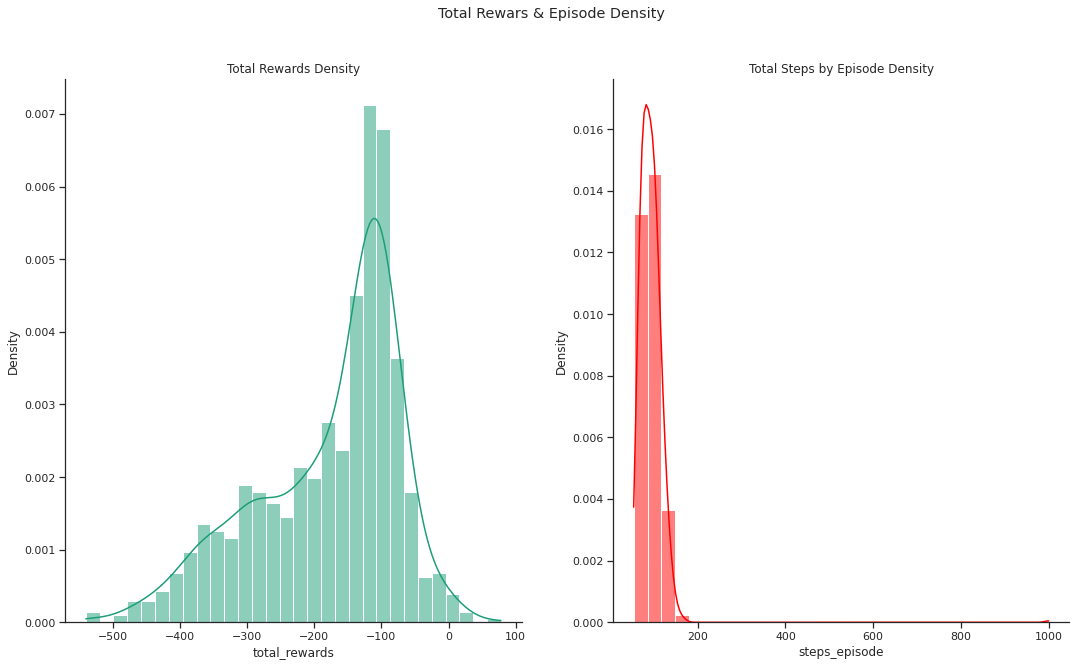

In [ ]:
plot_histograms('random_agent',total_rewards,steps_episode )

In [ ]:
print(f'[INFO]: Media de pasos por episodios obtenida: {np.mean(steps_episode)}')
print(f'[INFO]: Media de rencompensas obtenida: {np.mean(total_rewards)}')

[INFO]: Media de pasos por episodios obtenida: 93.203
[INFO]: Media de rencompensas obtenida: -179.00224076468731


In [ ]:
create_show_video_of_the_agent(ENV_NAME, 'Random_Agent_video',None, True)
show_video(ENV_NAME,'Random_Agent_video')

## 1.2) Ejercicio 1.2 (0.5 puntos)
Explicar los posibles espacios de observaciones y de acciones (informe escrito).

### Descripción del Entorno:

Información disponible en la memoria del proyecto. 


## B) Agente de referencia <a name="id5"></a>
En la tercera parte de la asignatura hemos introducido el agente DQN con replay buffer
y target network, que resulta ser un buen candidato para la solución del problema de
robótica que estamos analizando, visto que permite controlar entornos con un número
elevado de estados y acciones de forma eficiente.
Se pide resolver los 3 ejercicios siguientes. 

## 2.1) Ejercicio 2.1 (1.5 puntos)
Implementar un agente DQN para el entorno lunar-lander.

In [ ]:
# CONFIG First Agent

# Create Agent
ENV_NAME = "LunarLander-v2"
AGENT_NAME = 'DQN_agent'
MEMORY_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64
TARGET_UPDATE = 4
EPSILON_DECAY = 0.995
NN_UNITS = int(64)
GAMMA = 0.99  
TAU = 1e-3 
LR = 5e-4
MAX_EPSILON =  1.0
MIN_EPSILON = 0.01
THRESHOLD = 200
SEED = 123     
THRESHOLD = 200

# Train
N_EPISODES = 2000
CONSECUTIVE_EIPOSDES = 100

### Red Neuronal 
**Atención**. Como las redes neuronales tienes el mismo nombre para simplificar la creación de los agentes deberemos ejecutar la red neuronal correspondiente a este caso. 

In [ ]:
env = gym.make(ENV_NAME)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [ ]:
NN(obs_dim, action_dim , SEED, NN_UNITS)

NN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

### DQN Agent

In [ ]:
agentDQN = DQNAgent(ENV_NAME, 
        AGENT_NAME,
        MEMORY_SIZE,
        BATCH_SIZE,
        TARGET_UPDATE,
        EPSILON_DECAY,
        TAU,
        NN_UNITS,
        GAMMA,
        LR,
        MAX_EPSILON,
        MIN_EPSILON,
        THRESHOLD,
        SEED
        )


print(f'[INFO]: Agent DQN Created for [{agentDQN.env_name}] enviroment.')
print(f'[INFO]: Buffer Size: [{agentDQN.memory_size}].') 
print(f'[INFO]: Batch Size: [{agentDQN.batch_size}], Network Update：[{agentDQN.target_update}].')
print(f'[INFO]: Tau: [{agentDQN.tau}] and lr: [{agentDQN.lr}]. ')

[INFO]: Using: [cpu]
[INFO]: Agent DQN Created for [LunarLander-v2] enviroment.
[INFO]: Buffer Size: [100000].
[INFO]: Batch Size: [64], Network Update：[4].
[INFO]: Tau: [0.001] and lr: [0.0005]. 


Explicaciones

## 2.2) Ejercicio 2.2 (1 punto)

Entrenar el agente DQN y buscar los valores de los hiperparámetros que obtengan un
alto rendimiento del agente. Para ello, es necesario listar los hiperparámetros bajo
estudio y presentar las gráficas de las métricas que describen el aprendizaje.

#### Entrenamiento inicial


[TRAINING]: -------------------- Training Agent: DQN_agent--------------------



  5%|▌         | 101/2000 [00:14<05:41,  5.57it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [00:54<21:18,  1.41it/s]

  [INFO]: Episode 200	Average reward: -189.97


 15%|█▌        | 300/2000 [03:23<1:20:13,  2.83s/it]

  [INFO]: Episode 300	Average reward: -117.45


 20%|██        | 400/2000 [08:04<1:31:51,  3.44s/it]

  [INFO]: Episode 400	Average reward: -5.90


 25%|██▌       | 500/2000 [12:02<37:54,  1.52s/it]

  [INFO]: Episode 500	Average reward: 79.69


 30%|███       | 600/2000 [14:36<30:21,  1.30s/it]

  [INFO]: Episode 600	Average reward: 162.12


 35%|███▌      | 700/2000 [16:10<17:18,  1.25it/s]

  [INFO]: Episode 700	Average reward: 176.00


 40%|████      | 800/2000 [17:30<14:45,  1.36it/s]

  [INFO]: Episode 800	Average reward: 190.00


 45%|████▌     | 900/2000 [18:41<11:51,  1.55it/s]

  [INFO]: Episode 900	Average reward: 115.99


 50%|█████     | 1000/2000 [19:54<08:58,  1.86it/s]

  [INFO]: Episode 1000	Average reward: 166.02


 55%|█████▌    | 1100/2000 [20:54<09:20,  1.61it/s]

  [INFO]: Episode 1100	Average reward: 113.95


 60%|██████    | 1200/2000 [21:56<07:47,  1.71it/s]

  [INFO]: Episode 1200	Average reward: 108.19


 65%|██████▌   | 1300/2000 [23:16<12:56,  1.11s/it]

  [INFO]: Episode 1300	Average reward: 131.85


 70%|███████   | 1400/2000 [24:40<06:51,  1.46it/s]

  [INFO]: Episode 1400	Average reward: 54.19


 75%|███████▌  | 1500/2000 [26:24<08:11,  1.02it/s]

  [INFO]: Episode 1500	Average reward: 23.85


 80%|████████  | 1600/2000 [28:04<06:40,  1.00s/it]

  [INFO]: Episode 1600	Average reward: 121.67


 85%|████████▌ | 1700/2000 [29:15<02:51,  1.75it/s]

  [INFO]: Episode 1700	Average reward: 176.00


 90%|█████████ | 1800/2000 [30:23<02:03,  1.62it/s]

  [INFO]: Episode 1800	Average reward: 194.00


 95%|█████████▌| 1900/2000 [31:23<00:54,  1.84it/s]

  [INFO]: Episode 1900	Average reward: 186.00


 96%|█████████▌| 1922/2000 [31:37<00:45,  1.73it/s]


  [INFO]:  Environment has been solved in 1823 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



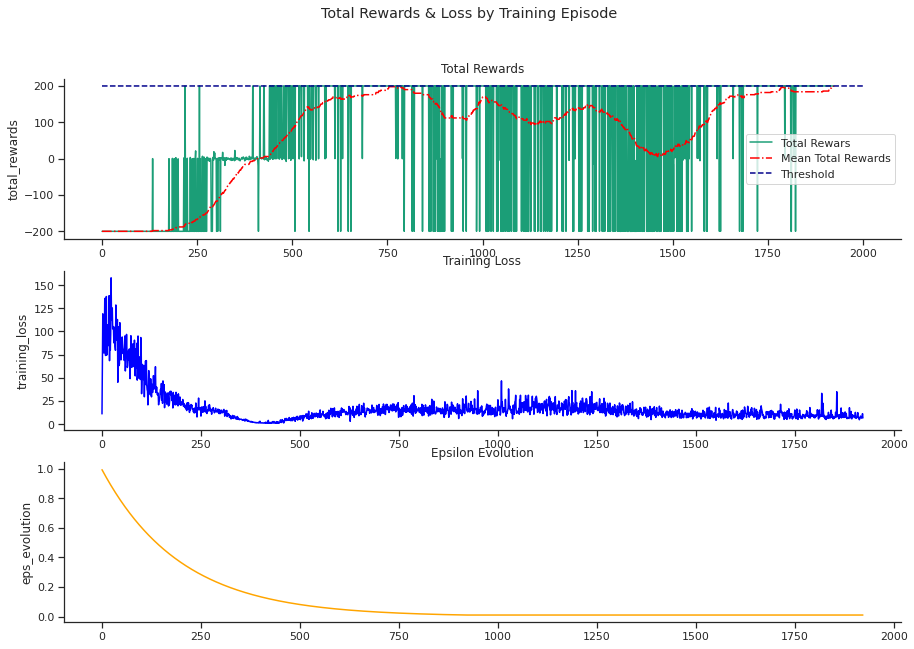

 96%|█████████▌| 1922/2000 [31:39<01:17,  1.01it/s]


In [ ]:
A_Reward_mean, A_training_time, A_solved_episode =  agentDQN.train(N_EPISODES)

In [ ]:
print(f'[INFO]: First Agent Metrics: Reward_Mean {A_Reward_mean}, Reward Std: {np.std(agentDQN.training_rewards)}')
print(f'[INFO]: Training Time {A_training_time}, Resolved episode {A_solved_episode}')

[INFO]: First Agent Metrics: Reward_Mean 79.67748651927434, Reward Std: 168.49953817051022
[INFO]: Training Time 31.65, Resolved episode 1823


Como criterio de comparación de los modelos utilizaremos las siguientes variables: la recompensa media, el tiempo de entrenamiento, y el episodio donde gemos encontrado la solución del problema. Además tendremos en cuenta la varianza de las recompensas para estudiar la robustez de cada modelo. 

#### Búsqueda de Hiperparámetros 

En primer lugar incrementaremos el número de unidades en las capas de la red neuronal, pasaremos de 64 unidades a 128,

In [ ]:
NN_UNITS = 128
NN(obs_dim, action_dim , SEED, NN_UNITS)

NN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

Mismos hiperparámetros que en el caso anterior:


In [ ]:
print(f'[INFO]: Agent DQN Created for [{agentDQN.env_name}] enviroment.')
print(f'[INFO]: Buffer Size: [{agentDQN.memory_size}].') 
print(f'[INFO]: Batch Size: [{agentDQN.batch_size}], Network Update：[{agentDQN.target_update}].')
print(f'[INFO]: Tau: [{agentDQN.tau}] and lr: [{agentDQN.lr}]. ')

[INFO]: Agent DQN Created for [LunarLander-v2] enviroment.
[INFO]: Buffer Size: [100000].
[INFO]: Batch Size: [64], Network Update：[4].
[INFO]: Tau: [0.001] and lr: [0.0005]. 


[INFO]: Using: [cpu]

[TRAINING]: -------------------- Training Agent: B_DQN_Agent--------------------



  5%|▌         | 101/2000 [00:16<05:52,  5.39it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [01:01<19:56,  1.50it/s]

  [INFO]: Episode 200	Average reward: -190.30


 15%|█▌        | 300/2000 [04:29<1:24:46,  2.99s/it]

  [INFO]: Episode 300	Average reward: -85.39


 20%|██        | 400/2000 [08:48<1:19:15,  2.97s/it]

  [INFO]: Episode 400	Average reward: -20.59


 25%|██▌       | 500/2000 [12:07<30:44,  1.23s/it]

  [INFO]: Episode 500	Average reward: 94.12


 30%|███       | 600/2000 [14:43<41:25,  1.78s/it]

  [INFO]: Episode 600	Average reward: 172.01


 35%|███▌      | 700/2000 [16:51<21:00,  1.03it/s]

  [INFO]: Episode 700	Average reward: 188.01


 40%|████      | 800/2000 [18:17<15:19,  1.31it/s]

  [INFO]: Episode 800	Average reward: 174.00


 45%|████▌     | 900/2000 [19:32<12:15,  1.50it/s]

  [INFO]: Episode 900	Average reward: 196.00


 50%|█████     | 1000/2000 [20:41<09:49,  1.70it/s]

  [INFO]: Episode 1000	Average reward: 194.00


 52%|█████▏    | 1049/2000 [21:08<09:26,  1.68it/s]


  [INFO]:  Environment has been solved in 950 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



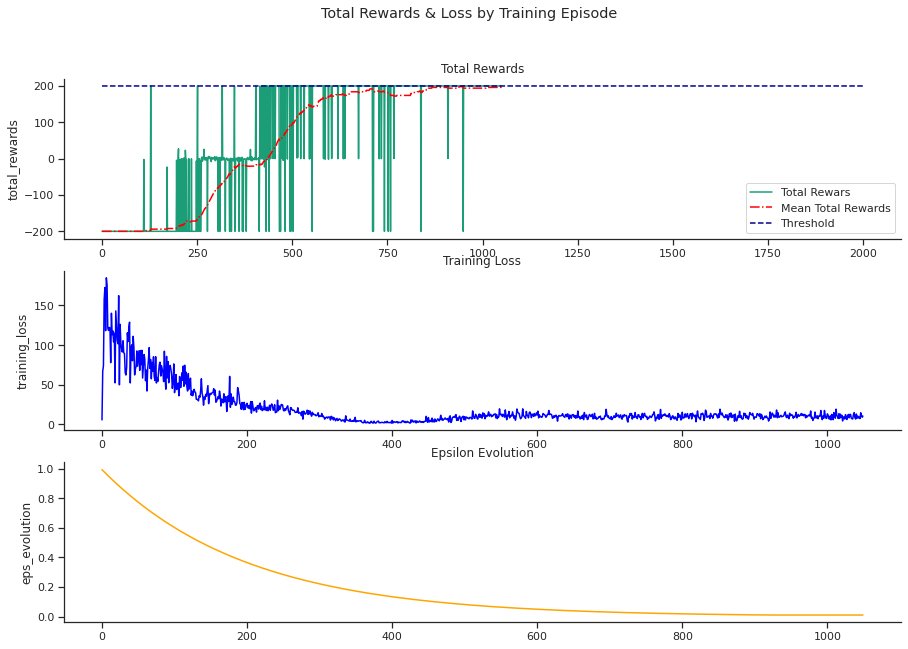

 52%|█████▏    | 1049/2000 [21:10<19:11,  1.21s/it]


In [ ]:
AGENT_NAME = 'B_DQN_Agent'

agentDQN = DQNAgent(ENV_NAME, 
        AGENT_NAME,
        MEMORY_SIZE,
        BATCH_SIZE,
        TARGET_UPDATE,
        EPSILON_DECAY,
        TAU,
        NN_UNITS,
        GAMMA,
        LR,
        MAX_EPSILON,
        MIN_EPSILON,
        THRESHOLD,
        SEED
        )

B_Reward_mean, B_training_time, B_solved_episode = agentDQN.train(N_EPISODES)

In [ ]:
print(f'[INFO]: First Agent Metrics: Reward_Mean {B_Reward_mean:.2f}, Reward Std: {np.std(agentDQN.training_rewards):.2f}')
print(f'[INFO]: Training Time {B_training_time:.2f}, Resolved episode {B_solved_episode:.2f}')

[INFO]: First Agent Metrics: Reward_Mean 59.23, Reward Std: 170.05
[INFO]: Training Time 21.18, Resolved episode 950.00


Hemos corrobodado que esta red neural nos ofrece unos mejores resultados. El paso siguiente será con esta red, identidifiar el resto de hiperparámetros más eficientes. 

Tras estudiar los cambios en el tamño de la red neuronal vamos a proceder al estudio del resto de hiperparáemtros más importabtes como son: el batch size, Learning Rate, o el factor de descuento.


Buscaremos los hiperparámetros con una libreria llamada Optuna que utiliza metodos de busqueda bayesana para encontrar estos hyperparametros de la forma más eficiente posible. 

In [ ]:
L_BATCH_SIZE = [32, 64, 128]         # minibatch size
L_GAMMA = [0.99]            # Reducir el factor de descuento no funciona
L_LR = [5e-4,3e-4,2e-4,1e-4]  # learning rate 
NN_UNITS = 128            
FIRST_CSV_NAME = 'DQN_Best_models.csv'

[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 1 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0005]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 1_DQN_Agent--------------------



  5%|▌         | 101/2000 [00:20<05:35,  5.67it/s]

  [INFO]: Episode 100	Average reward: -197.98


 10%|█         | 200/2000 [01:06<22:04,  1.36it/s]

  [INFO]: Episode 200	Average reward: -188.05


 15%|█▌        | 300/2000 [04:04<1:13:51,  2.61s/it]

  [INFO]: Episode 300	Average reward: -88.58


 20%|██        | 400/2000 [08:16<56:06,  2.10s/it]  

  [INFO]: Episode 400	Average reward: 13.19


 25%|██▌       | 500/2000 [10:35<26:55,  1.08s/it]

  [INFO]: Episode 500	Average reward: 147.62


 30%|███       | 600/2000 [12:30<18:40,  1.25it/s]

  [INFO]: Episode 600	Average reward: 175.96


 35%|███▌      | 700/2000 [14:02<13:07,  1.65it/s]

  [INFO]: Episode 700	Average reward: 194.00


 40%|████      | 800/2000 [15:10<18:14,  1.10it/s]

  [INFO]: Episode 800	Average reward: 184.00


 45%|████▌     | 900/2000 [16:18<23:22,  1.27s/it]

  [INFO]: Episode 900	Average reward: 190.00


 47%|████▋     | 933/2000 [16:36<11:51,  1.50it/s]


  [INFO]:  Environment has been solved in 834 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



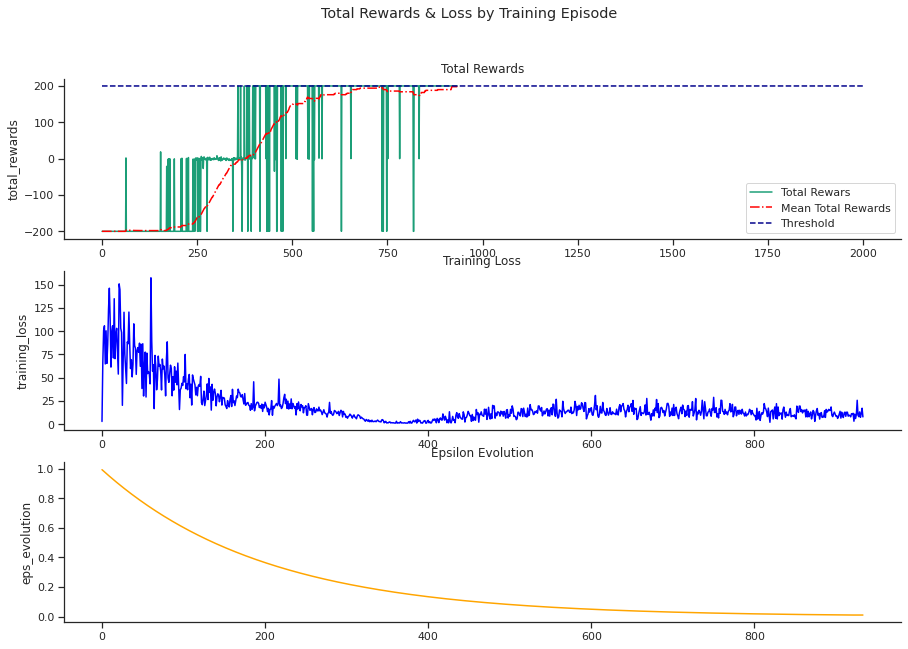

 47%|████▋     | 933/2000 [16:37<19:00,  1.07s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 2 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0003]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 2_DQN_Agent--------------------



  5%|▌         | 101/2000 [00:15<05:35,  5.66it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [00:49<28:44,  1.04it/s]

  [INFO]: Episode 200	Average reward: -195.98


 15%|█▌        | 300/2000 [03:26<1:18:25,  2.77s/it]

  [INFO]: Episode 300	Average reward: -124.11


 20%|██        | 400/2000 [08:17<1:12:22,  2.71s/it]

  [INFO]: Episode 400	Average reward: -0.41


 25%|██▌       | 500/2000 [12:07<47:59,  1.92s/it]

  [INFO]: Episode 500	Average reward: 40.17


 30%|███       | 600/2000 [14:21<27:12,  1.17s/it]

  [INFO]: Episode 600	Average reward: 160.03


 35%|███▌      | 700/2000 [16:05<20:08,  1.08it/s]

  [INFO]: Episode 700	Average reward: 186.01


 40%|████      | 800/2000 [17:51<19:15,  1.04it/s]

  [INFO]: Episode 800	Average reward: 158.02


 45%|████▌     | 900/2000 [19:33<19:03,  1.04s/it]

  [INFO]: Episode 900	Average reward: 162.00


 50%|█████     | 1000/2000 [20:55<12:46,  1.30it/s]

  [INFO]: Episode 1000	Average reward: 196.00


 55%|█████▌    | 1100/2000 [22:02<08:19,  1.80it/s]

  [INFO]: Episode 1100	Average reward: 190.05


 60%|██████    | 1200/2000 [23:02<07:10,  1.86it/s]

  [INFO]: Episode 1200	Average reward: 182.02


 65%|██████▌   | 1300/2000 [23:55<03:58,  2.93it/s]

  [INFO]: Episode 1300	Average reward: 186.00


 70%|███████   | 1400/2000 [24:43<04:15,  2.35it/s]

  [INFO]: Episode 1400	Average reward: 184.00


 75%|███████▌  | 1500/2000 [25:29<04:27,  1.87it/s]

  [INFO]: Episode 1500	Average reward: 184.00


 80%|████████  | 1600/2000 [26:15<02:58,  2.25it/s]

  [INFO]: Episode 1600	Average reward: 138.00


 85%|████████▌ | 1700/2000 [26:59<02:15,  2.21it/s]

  [INFO]: Episode 1700	Average reward: 152.00


 90%|█████████ | 1800/2000 [27:51<01:17,  2.59it/s]

  [INFO]: Episode 1800	Average reward: 156.00


 95%|█████████▌| 1900/2000 [28:42<00:46,  2.16it/s]

  [INFO]: Episode 1900	Average reward: 162.00


100%|█████████▉| 1999/2000 [29:36<00:00,  1.50it/s]

  [INFO]: Episode 2000	Average reward: 165.98


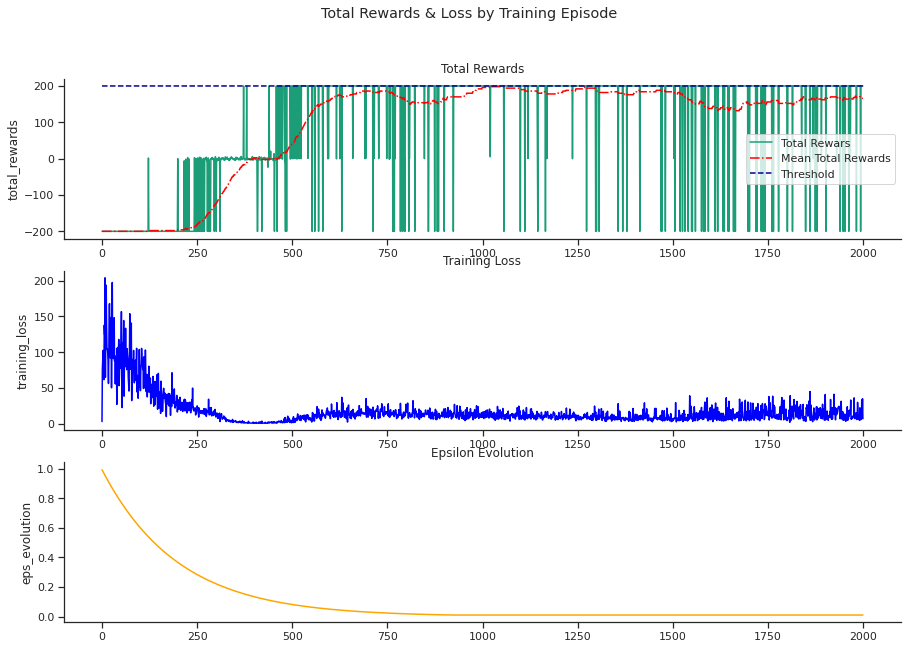

100%|██████████| 2000/2000 [29:38<00:00,  1.12it/s]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 3 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0002]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 3_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:15<06:55,  4.58it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [00:47<09:43,  3.09it/s]

  [INFO]: Episode 200	Average reward: -196.11


 15%|█▌        | 300/2000 [02:19<32:47,  1.16s/it]

  [INFO]: Episode 300	Average reward: -173.71


 20%|██        | 400/2000 [06:53<1:28:18,  3.31s/it]

  [INFO]: Episode 400	Average reward: -27.86


 25%|██▌       | 500/2000 [11:14<56:12,  2.25s/it]

  [INFO]: Episode 500	Average reward: 18.04


 30%|███       | 600/2000 [14:42<57:42,  2.47s/it]

  [INFO]: Episode 600	Average reward: 53.90


 35%|███▌      | 700/2000 [18:06<36:16,  1.67s/it]

  [INFO]: Episode 700	Average reward: 121.97


 40%|████      | 800/2000 [20:47<30:20,  1.52s/it]

  [INFO]: Episode 800	Average reward: 159.99


 45%|████▌     | 900/2000 [23:15<25:17,  1.38s/it]

  [INFO]: Episode 900	Average reward: 173.99


 50%|█████     | 1000/2000 [25:10<22:57,  1.38s/it]

  [INFO]: Episode 1000	Average reward: 162.00


 55%|█████▌    | 1100/2000 [26:48<10:26,  1.44it/s]

  [INFO]: Episode 1100	Average reward: 138.01


 60%|██████    | 1200/2000 [28:05<11:20,  1.18it/s]

  [INFO]: Episode 1200	Average reward: 174.00


 65%|██████▌   | 1300/2000 [29:21<07:51,  1.49it/s]

  [INFO]: Episode 1300	Average reward: 76.00


 70%|███████   | 1400/2000 [30:45<11:39,  1.17s/it]

  [INFO]: Episode 1400	Average reward: 79.95


 75%|███████▌  | 1500/2000 [32:19<05:26,  1.53it/s]

  [INFO]: Episode 1500	Average reward: 117.94


 80%|████████  | 1600/2000 [33:24<03:06,  2.15it/s]

  [INFO]: Episode 1600	Average reward: 181.96


 82%|████████▏ | 1633/2000 [33:39<02:27,  2.49it/s]


  [INFO]:  Environment has been solved in 1534 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



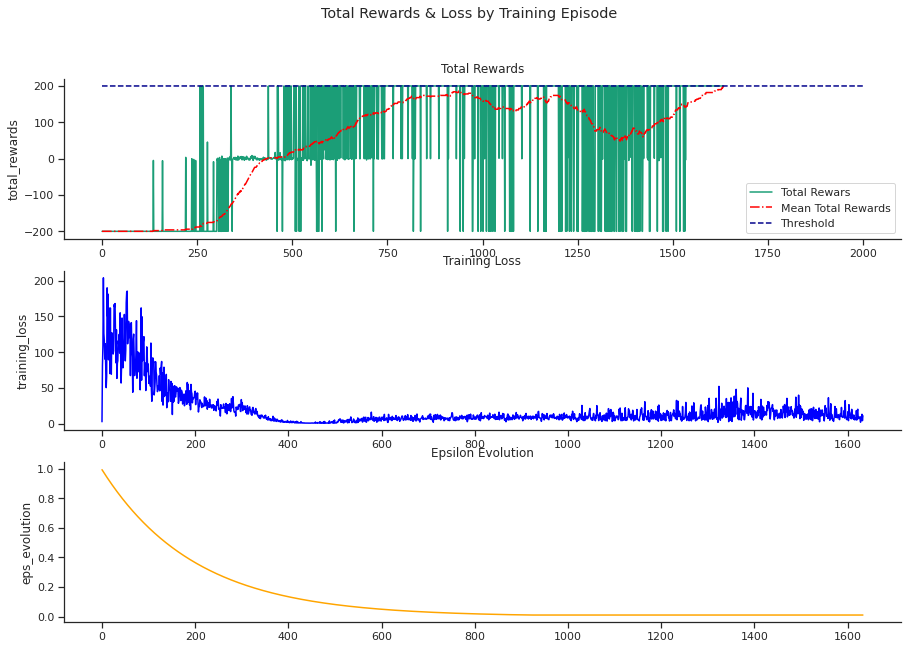

 82%|████████▏ | 1633/2000 [33:41<07:34,  1.24s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 4 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0001]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 4_DQN_Agent--------------------



  5%|▌         | 101/2000 [00:16<06:50,  4.62it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [00:44<09:08,  3.28it/s]

  [INFO]: Episode 200	Average reward: -200.00


 15%|█▌        | 300/2000 [01:34<29:33,  1.04s/it]

  [INFO]: Episode 300	Average reward: -200.00


 20%|██        | 400/2000 [03:26<55:48,  2.09s/it]

  [INFO]: Episode 400	Average reward: -185.99


 25%|██▌       | 500/2000 [08:01<1:11:14,  2.85s/it]

  [INFO]: Episode 500	Average reward: -17.69


 30%|███       | 600/2000 [12:42<1:01:01,  2.62s/it]

  [INFO]: Episode 600	Average reward: -0.03


 35%|███▌      | 700/2000 [17:29<58:46,  2.71s/it]

  [INFO]: Episode 700	Average reward: -2.17


 40%|████      | 800/2000 [22:11<54:27,  2.72s/it]

  [INFO]: Episode 800	Average reward: -2.29


 45%|████▌     | 900/2000 [26:43<51:08,  2.79s/it]

  [INFO]: Episode 900	Average reward: -6.57


 50%|█████     | 1000/2000 [31:19<42:07,  2.53s/it]

  [INFO]: Episode 1000	Average reward: -0.42


 55%|█████▌    | 1101/2000 [35:22<20:36,  1.38s/it]

  [INFO]: Episode 1100	Average reward: -32.39


 60%|██████    | 1200/2000 [39:49<41:29,  3.11s/it]

  [INFO]: Episode 1200	Average reward: -14.78


 65%|██████▌   | 1300/2000 [44:36<31:02,  2.66s/it]

  [INFO]: Episode 1300	Average reward: -0.52


 70%|███████   | 1400/2000 [49:00<28:00,  2.80s/it]

  [INFO]: Episode 1400	Average reward: 0.33


 75%|███████▌  | 1500/2000 [53:20<22:23,  2.69s/it]

  [INFO]: Episode 1500	Average reward: 2.20


 80%|████████  | 1600/2000 [57:06<12:47,  1.92s/it]

  [INFO]: Episode 1600	Average reward: 49.32


 85%|████████▌ | 1700/2000 [59:50<04:13,  1.18it/s]

  [INFO]: Episode 1700	Average reward: 65.71


 90%|█████████ | 1800/2000 [1:02:53<07:42,  2.31s/it]

  [INFO]: Episode 1800	Average reward: 75.76


 95%|█████████▌| 1900/2000 [1:06:10<02:57,  1.78s/it]

  [INFO]: Episode 1900	Average reward: 95.67


100%|█████████▉| 1999/2000 [1:09:02<00:01,  1.10s/it]

  [INFO]: Episode 2000	Average reward: 125.75


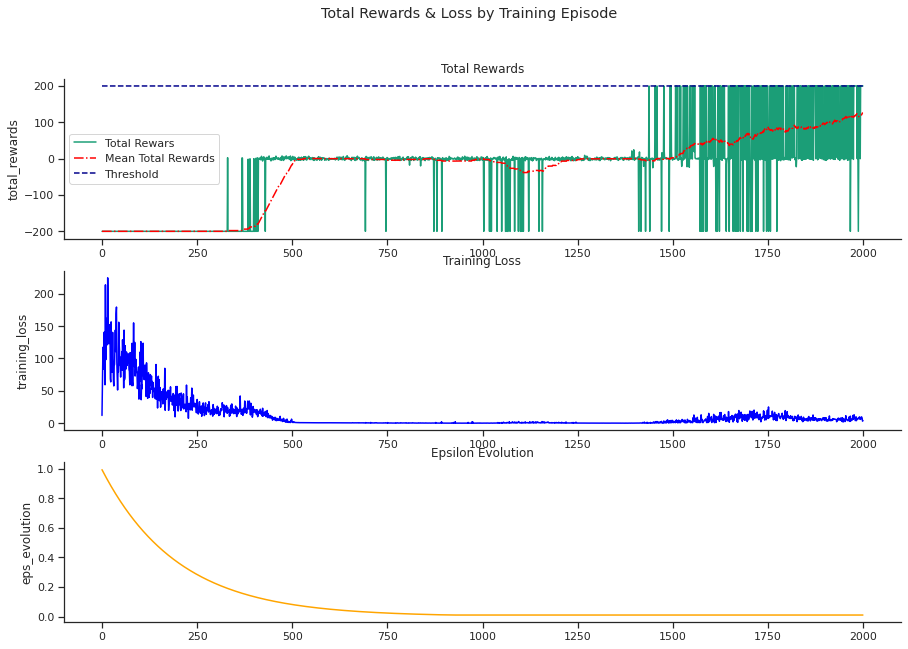

100%|██████████| 2000/2000 [1:09:04<00:00,  2.07s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 5 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0005]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 5_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:18<07:25,  4.26it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [01:19<19:09,  1.57it/s]

  [INFO]: Episode 200	Average reward: -181.80


 15%|█▌        | 300/2000 [04:35<44:45,  1.58s/it]  

  [INFO]: Episode 300	Average reward: -88.02


 20%|██        | 400/2000 [09:09<1:19:39,  2.99s/it]

  [INFO]: Episode 400	Average reward: -15.84


 25%|██▌       | 500/2000 [13:49<1:03:04,  2.52s/it]

  [INFO]: Episode 500	Average reward: 50.28


 30%|███       | 600/2000 [16:21<16:39,  1.40it/s]

  [INFO]: Episode 600	Average reward: 164.07


 35%|███▌      | 700/2000 [17:44<14:26,  1.50it/s]

  [INFO]: Episode 700	Average reward: 180.00


 40%|████      | 800/2000 [18:44<11:26,  1.75it/s]

  [INFO]: Episode 800	Average reward: 164.00


 45%|████▌     | 900/2000 [19:40<09:07,  2.01it/s]

  [INFO]: Episode 900	Average reward: 158.00


 50%|█████     | 1000/2000 [20:40<10:41,  1.56it/s]

  [INFO]: Episode 1000	Average reward: 168.00


 55%|█████▌    | 1100/2000 [21:55<13:46,  1.09it/s]

  [INFO]: Episode 1100	Average reward: 164.06


 60%|██████    | 1200/2000 [23:18<08:44,  1.53it/s]

  [INFO]: Episode 1200	Average reward: 177.90


 65%|██████▌   | 1300/2000 [24:39<09:51,  1.18it/s]

  [INFO]: Episode 1300	Average reward: 183.97


 70%|███████   | 1400/2000 [25:33<04:13,  2.37it/s]

  [INFO]: Episode 1400	Average reward: 196.00


 70%|███████   | 1401/2000 [25:34<04:00,  2.49it/s]


  [INFO]:  Environment has been solved in 1302 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



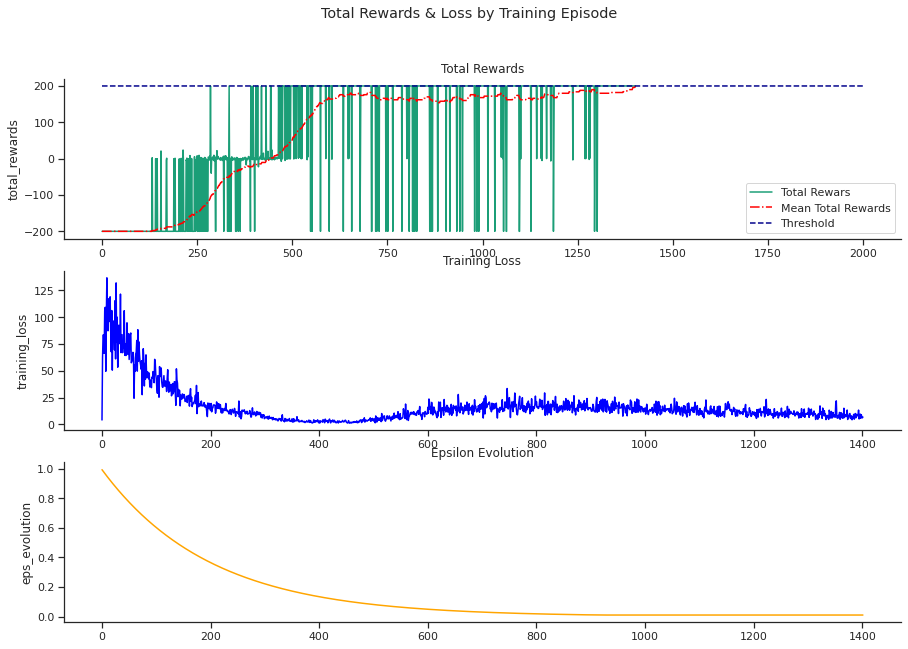

 70%|███████   | 1401/2000 [25:35<10:56,  1.10s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 6 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0003]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 6_DQN_Agent--------------------



  5%|▌         | 101/2000 [00:18<07:06,  4.46it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [00:54<12:08,  2.47it/s]

  [INFO]: Episode 200	Average reward: -196.03


 15%|█▌        | 300/2000 [02:51<1:21:55,  2.89s/it]

  [INFO]: Episode 300	Average reward: -172.04


 20%|██        | 400/2000 [08:08<1:23:15,  3.12s/it]

  [INFO]: Episode 400	Average reward: 1.93


 25%|██▌       | 500/2000 [13:00<1:19:16,  3.17s/it]

  [INFO]: Episode 500	Average reward: 3.63


 30%|███       | 600/2000 [16:42<33:02,  1.42s/it]

  [INFO]: Episode 600	Average reward: 140.04


 35%|███▌      | 700/2000 [18:17<13:12,  1.64it/s]

  [INFO]: Episode 700	Average reward: 192.00


 40%|████      | 800/2000 [19:41<13:33,  1.48it/s]

  [INFO]: Episode 800	Average reward: 143.95


 45%|████▌     | 900/2000 [21:21<22:39,  1.24s/it]

  [INFO]: Episode 900	Average reward: 149.90


 50%|█████     | 1000/2000 [22:35<18:57,  1.14s/it]

  [INFO]: Episode 1000	Average reward: 159.87


 55%|█████▌    | 1100/2000 [23:44<09:02,  1.66it/s]

  [INFO]: Episode 1100	Average reward: 192.03


 60%|██████    | 1200/2000 [24:52<09:07,  1.46it/s]

  [INFO]: Episode 1200	Average reward: 135.90


 65%|██████▌   | 1300/2000 [25:55<07:33,  1.54it/s]

  [INFO]: Episode 1300	Average reward: 152.00


 70%|███████   | 1400/2000 [26:48<04:46,  2.10it/s]

  [INFO]: Episode 1400	Average reward: 192.00


 75%|███████▌  | 1500/2000 [27:45<04:35,  1.82it/s]

  [INFO]: Episode 1500	Average reward: 190.00


 79%|███████▉  | 1577/2000 [28:29<03:25,  2.06it/s]


  [INFO]:  Environment has been solved in 1478 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



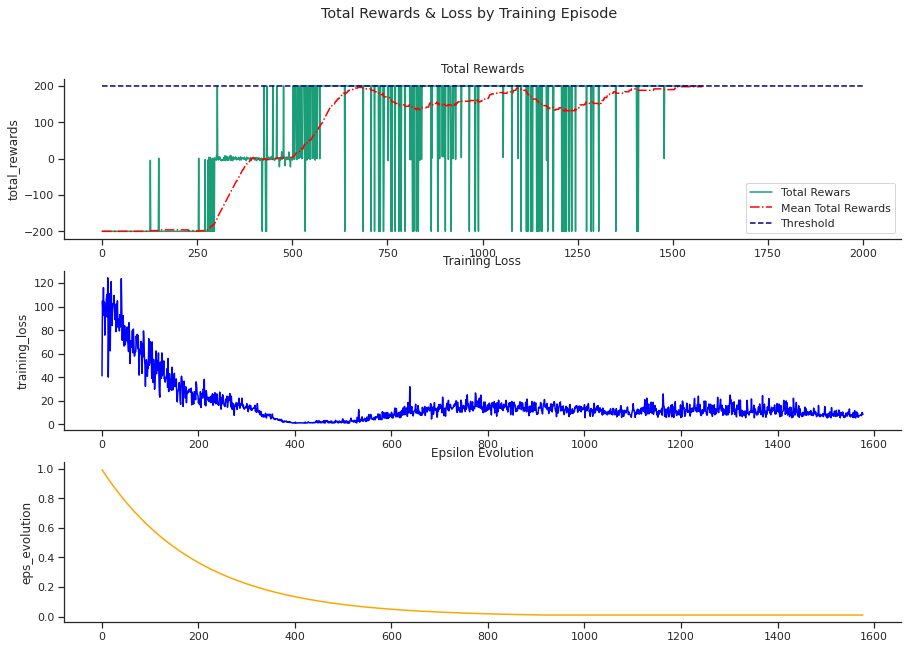

 79%|███████▉  | 1577/2000 [28:31<07:39,  1.09s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 7 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0002]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 7_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:17<06:58,  4.54it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 201/2000 [01:07<13:08,  2.28it/s]

  [INFO]: Episode 200	Average reward: -190.11


 15%|█▌        | 300/2000 [04:13<37:33,  1.33s/it]

  [INFO]: Episode 300	Average reward: -73.45


 20%|██        | 400/2000 [08:09<46:25,  1.74s/it]

  [INFO]: Episode 400	Average reward: 52.83


 25%|██▌       | 500/2000 [10:54<26:03,  1.04s/it]

  [INFO]: Episode 500	Average reward: 156.01


 30%|███       | 600/2000 [12:54<22:39,  1.03it/s]

  [INFO]: Episode 600	Average reward: 162.00


 35%|███▌      | 700/2000 [14:43<37:09,  1.72s/it]

  [INFO]: Episode 700	Average reward: 178.03


 40%|████      | 800/2000 [16:27<22:59,  1.15s/it]

  [INFO]: Episode 800	Average reward: 171.99


 45%|████▌     | 900/2000 [17:42<12:55,  1.42it/s]

  [INFO]: Episode 900	Average reward: 174.01


 50%|█████     | 1000/2000 [18:51<12:19,  1.35it/s]

  [INFO]: Episode 1000	Average reward: 178.00


 55%|█████▌    | 1100/2000 [19:57<09:07,  1.64it/s]

  [INFO]: Episode 1100	Average reward: 184.00


 60%|██████    | 1200/2000 [20:59<08:22,  1.59it/s]

  [INFO]: Episode 1200	Average reward: 180.00


 65%|██████▌   | 1300/2000 [22:11<07:30,  1.55it/s]

  [INFO]: Episode 1300	Average reward: 187.93


 70%|███████   | 1400/2000 [23:16<05:36,  1.78it/s]

  [INFO]: Episode 1400	Average reward: 186.05


 75%|███████▌  | 1500/2000 [24:14<04:14,  1.96it/s]

  [INFO]: Episode 1500	Average reward: 188.00


 80%|████████  | 1600/2000 [25:09<02:55,  2.28it/s]

  [INFO]: Episode 1600	Average reward: 178.00


 85%|████████▌ | 1700/2000 [25:57<02:45,  1.82it/s]

  [INFO]: Episode 1700	Average reward: 178.00


 90%|█████████ | 1800/2000 [26:46<01:25,  2.34it/s]

  [INFO]: Episode 1800	Average reward: 188.00


 95%|█████████▌| 1900/2000 [27:31<01:06,  1.51it/s]

  [INFO]: Episode 1900	Average reward: 198.00


100%|█████████▉| 1999/2000 [28:18<00:00,  2.67it/s]

  [INFO]: Episode 2000	Average reward: 192.00


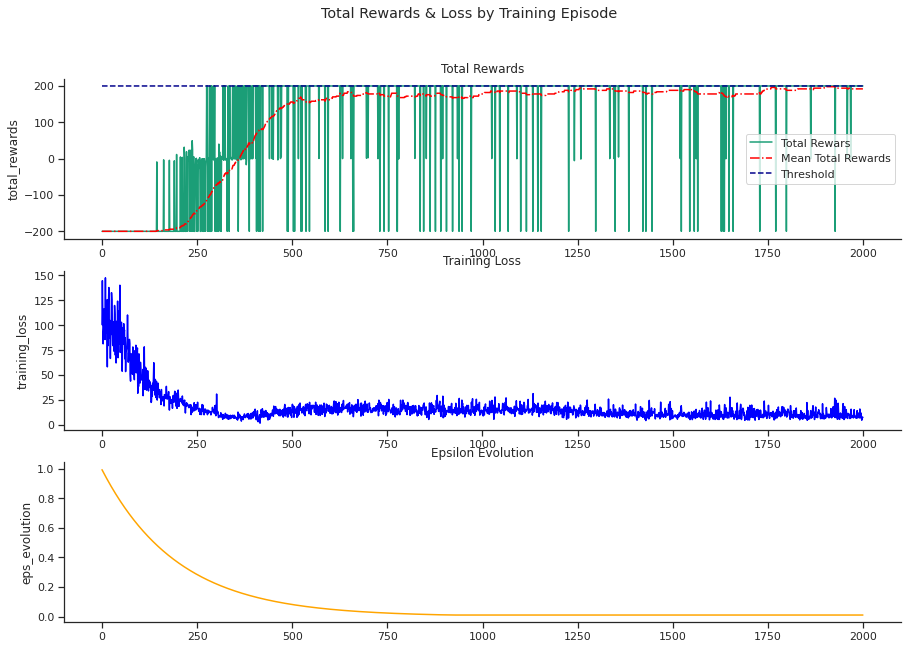

100%|██████████| 2000/2000 [28:21<00:00,  1.18it/s]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 8 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0001]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 8_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:17<06:33,  4.83it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [00:55<12:28,  2.41it/s]

  [INFO]: Episode 200	Average reward: -198.01


 15%|█▌        | 300/2000 [02:12<31:29,  1.11s/it]

  [INFO]: Episode 300	Average reward: -179.51


 20%|██        | 400/2000 [06:46<1:09:58,  2.62s/it]

  [INFO]: Episode 400	Average reward: -8.17


 25%|██▌       | 501/2000 [11:18<26:44,  1.07s/it]

  [INFO]: Episode 500	Average reward: -3.84


 30%|███       | 600/2000 [14:23<43:22,  1.86s/it]

  [INFO]: Episode 600	Average reward: 48.54


 35%|███▌      | 700/2000 [17:23<41:40,  1.92s/it]

  [INFO]: Episode 700	Average reward: 182.06


 40%|████      | 800/2000 [19:45<23:52,  1.19s/it]

  [INFO]: Episode 800	Average reward: 194.00


 45%|████▌     | 900/2000 [21:32<14:30,  1.26it/s]

  [INFO]: Episode 900	Average reward: 176.01


 50%|█████     | 1000/2000 [23:09<14:47,  1.13it/s]

  [INFO]: Episode 1000	Average reward: 152.00


 55%|█████▌    | 1100/2000 [24:42<12:34,  1.19it/s]

  [INFO]: Episode 1100	Average reward: 152.05


 60%|██████    | 1200/2000 [26:03<16:56,  1.27s/it]

  [INFO]: Episode 1200	Average reward: 177.98


 65%|██████▌   | 1300/2000 [27:22<07:10,  1.62it/s]

  [INFO]: Episode 1300	Average reward: 192.00


 70%|███████   | 1400/2000 [28:54<12:13,  1.22s/it]

  [INFO]: Episode 1400	Average reward: 177.99


 75%|███████▌  | 1500/2000 [30:03<06:06,  1.36it/s]

  [INFO]: Episode 1500	Average reward: 159.99


 80%|████████  | 1600/2000 [31:05<02:31,  2.63it/s]

  [INFO]: Episode 1600	Average reward: 182.05


 85%|████████▌ | 1700/2000 [32:05<02:21,  2.12it/s]

  [INFO]: Episode 1700	Average reward: 166.00


 90%|█████████ | 1800/2000 [33:09<01:41,  1.97it/s]

  [INFO]: Episode 1800	Average reward: 176.01


 95%|█████████▌| 1900/2000 [33:55<00:42,  2.37it/s]

  [INFO]: Episode 1900	Average reward: 168.00


100%|█████████▉| 1999/2000 [34:46<00:00,  1.05it/s]

  [INFO]: Episode 2000	Average reward: 148.00


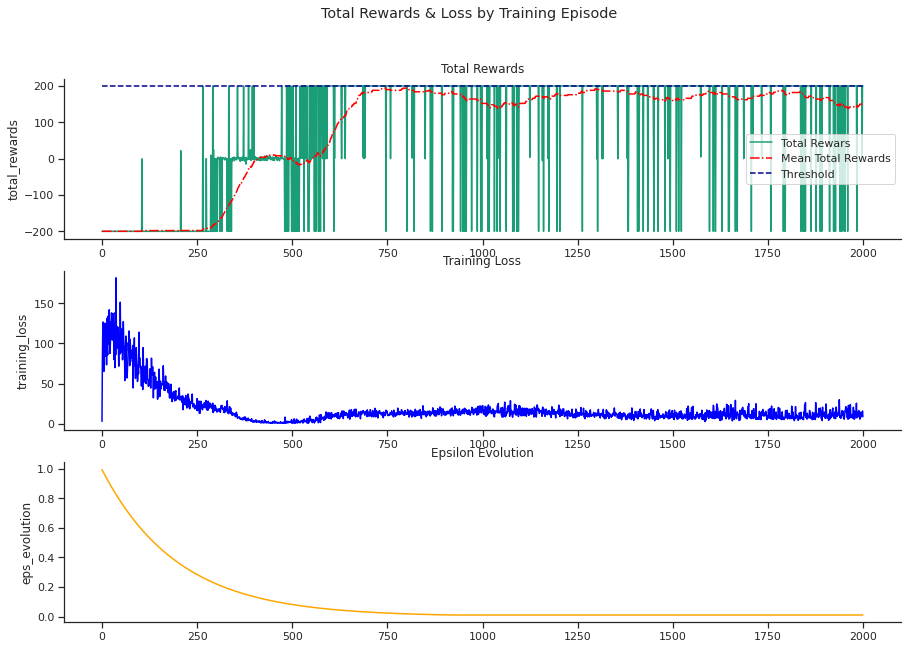

100%|██████████| 2000/2000 [34:49<00:00,  1.04s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 9 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0005]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 9_DQN_Agent--------------------



  5%|▌         | 101/2000 [00:20<07:52,  4.02it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [01:22<42:07,  1.40s/it]

  [INFO]: Episode 200	Average reward: -184.62


 15%|█▌        | 300/2000 [05:20<1:32:23,  3.26s/it]

  [INFO]: Episode 300	Average reward: -71.44


 20%|██        | 400/2000 [09:40<42:58,  1.61s/it]

  [INFO]: Episode 400	Average reward: -2.29


 25%|██▌       | 500/2000 [13:34<41:28,  1.66s/it]

  [INFO]: Episode 500	Average reward: 120.04


 30%|███       | 600/2000 [15:42<18:02,  1.29it/s]

  [INFO]: Episode 600	Average reward: 172.00


 35%|███▍      | 698/2000 [17:10<14:48,  1.47it/s]


  [INFO]:  Environment has been solved in 599 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



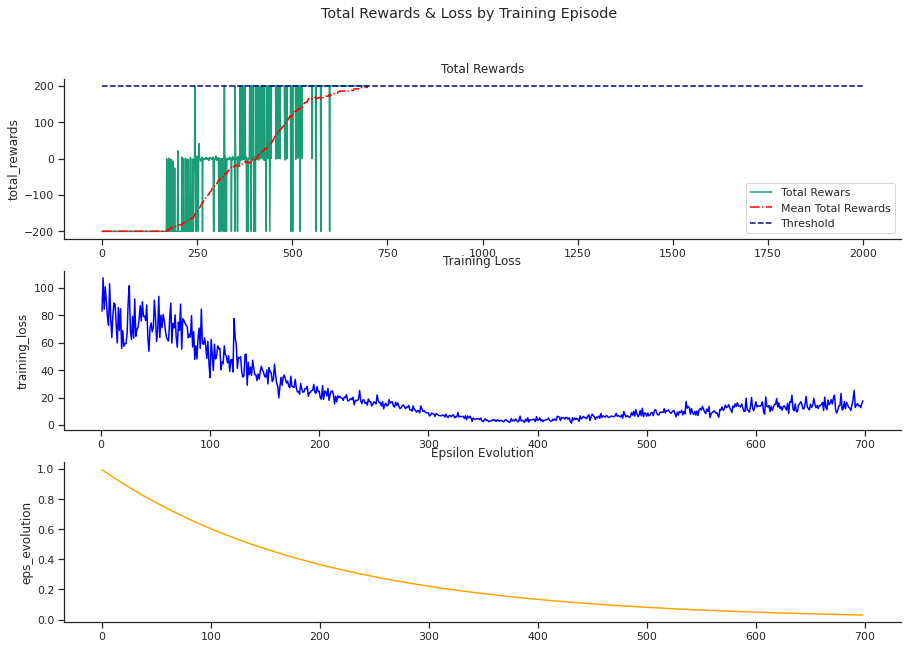

 35%|███▍      | 698/2000 [17:12<32:05,  1.48s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 10 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0003]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 10_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:20<09:16,  3.42it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [01:19<28:20,  1.06it/s]

  [INFO]: Episode 200	Average reward: -180.42


 15%|█▌        | 300/2000 [04:49<1:49:32,  3.87s/it]

  [INFO]: Episode 300	Average reward: -94.00


 20%|██        | 400/2000 [10:11<1:22:47,  3.10s/it]

  [INFO]: Episode 400	Average reward: -0.18


 25%|██▌       | 500/2000 [14:28<1:06:21,  2.65s/it]

  [INFO]: Episode 500	Average reward: 74.21


 30%|███       | 600/2000 [17:18<13:24,  1.74it/s]

  [INFO]: Episode 600	Average reward: 134.09


 35%|███▌      | 700/2000 [18:51<16:37,  1.30it/s]

  [INFO]: Episode 700	Average reward: 88.00


 40%|████      | 800/2000 [19:56<19:48,  1.01it/s]

  [INFO]: Episode 800	Average reward: 160.00


 45%|████▌     | 900/2000 [21:00<08:58,  2.04it/s]

  [INFO]: Episode 900	Average reward: 192.00


 50%|█████     | 1000/2000 [21:56<08:39,  1.92it/s]

  [INFO]: Episode 1000	Average reward: 194.00


 55%|█████▌    | 1100/2000 [23:01<07:48,  1.92it/s]

  [INFO]: Episode 1100	Average reward: 190.00


 60%|██████    | 1200/2000 [24:08<07:54,  1.69it/s]

  [INFO]: Episode 1200	Average reward: 178.00


 65%|██████▌   | 1300/2000 [25:15<10:40,  1.09it/s]

  [INFO]: Episode 1300	Average reward: 183.99


 70%|███████   | 1400/2000 [26:18<06:20,  1.57it/s]

  [INFO]: Episode 1400	Average reward: 180.00


 75%|███████▌  | 1500/2000 [27:28<04:01,  2.07it/s]

  [INFO]: Episode 1500	Average reward: 160.00


 80%|████████  | 1600/2000 [28:33<04:20,  1.54it/s]

  [INFO]: Episode 1600	Average reward: 194.02


 85%|████████▌ | 1700/2000 [29:35<03:27,  1.45it/s]

  [INFO]: Episode 1700	Average reward: 196.00


 90%|█████████ | 1800/2000 [30:32<01:44,  1.92it/s]

  [INFO]: Episode 1800	Average reward: 191.99


 95%|█████████▌| 1900/2000 [31:29<00:47,  2.12it/s]

  [INFO]: Episode 1900	Average reward: 198.00


 96%|█████████▌| 1912/2000 [31:37<00:53,  1.64it/s]


  [INFO]:  Environment has been solved in 1813 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



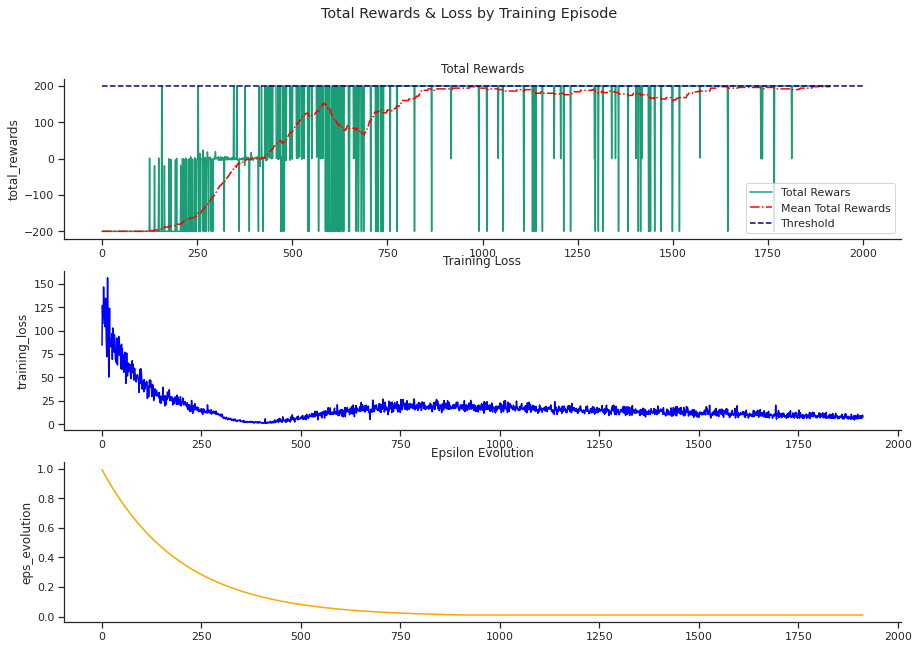

 96%|█████████▌| 1912/2000 [31:40<01:27,  1.01it/s]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 11 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0002]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 11_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:22<10:25,  3.04it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [01:10<17:26,  1.72it/s]

  [INFO]: Episode 200	Average reward: -198.00


 15%|█▌        | 300/2000 [04:38<1:46:33,  3.76s/it]

  [INFO]: Episode 300	Average reward: -98.25


 20%|██        | 400/2000 [10:18<1:20:19,  3.01s/it]

  [INFO]: Episode 400	Average reward: 5.94


 25%|██▌       | 500/2000 [14:16<52:41,  2.11s/it]

  [INFO]: Episode 500	Average reward: 98.01


 30%|███       | 600/2000 [17:53<31:08,  1.33s/it]

  [INFO]: Episode 600	Average reward: 140.07


 35%|███▌      | 700/2000 [19:55<16:10,  1.34it/s]

  [INFO]: Episode 700	Average reward: 178.00


 40%|████      | 800/2000 [21:23<13:02,  1.53it/s]

  [INFO]: Episode 800	Average reward: 174.00


 45%|████▌     | 900/2000 [22:38<13:50,  1.32it/s]

  [INFO]: Episode 900	Average reward: 168.00


 50%|█████     | 1000/2000 [23:53<12:19,  1.35it/s]

  [INFO]: Episode 1000	Average reward: 122.00


 55%|█████▌    | 1100/2000 [25:11<11:04,  1.35it/s]

  [INFO]: Episode 1100	Average reward: 160.00


 60%|██████    | 1200/2000 [26:21<07:49,  1.70it/s]

  [INFO]: Episode 1200	Average reward: 182.00


 62%|██████▏   | 1234/2000 [26:43<07:04,  1.80it/s]


  [INFO]:  Environment has been solved in 1135 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



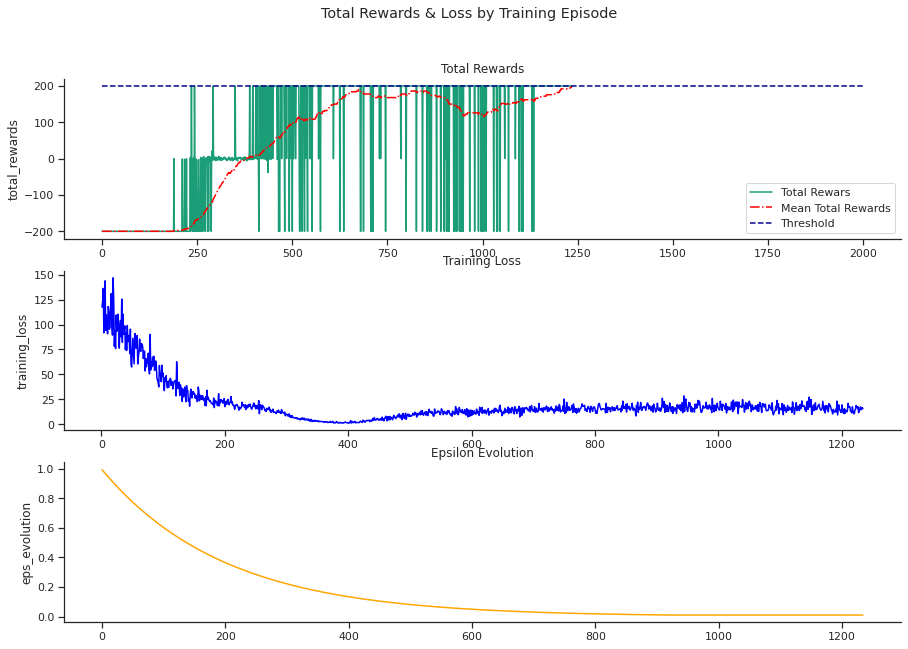

 62%|██████▏   | 1234/2000 [26:45<16:36,  1.30s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 12 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0001]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 12_DQN_Agent--------------------



  5%|▌         | 100/2000 [00:21<07:25,  4.27it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [01:06<13:08,  2.28it/s]

  [INFO]: Episode 200	Average reward: -200.00


 15%|█▌        | 300/2000 [02:50<44:20,  1.57s/it]

  [INFO]: Episode 300	Average reward: -166.17


 20%|██        | 400/2000 [07:58<1:31:19,  3.42s/it]

  [INFO]: Episode 400	Average reward: -17.64


 25%|██▌       | 500/2000 [13:01<1:10:09,  2.81s/it]

  [INFO]: Episode 500	Average reward: 3.36


 30%|███       | 600/2000 [17:18<1:07:36,  2.90s/it]

  [INFO]: Episode 600	Average reward: 104.05


 35%|███▌      | 700/2000 [20:50<37:38,  1.74s/it]

  [INFO]: Episode 700	Average reward: 171.80


 40%|████      | 800/2000 [23:26<36:13,  1.81s/it]

  [INFO]: Episode 800	Average reward: 160.00


 45%|████▌     | 900/2000 [26:05<23:38,  1.29s/it]

  [INFO]: Episode 900	Average reward: 162.02


 50%|█████     | 1000/2000 [28:57<23:26,  1.41s/it]

  [INFO]: Episode 1000	Average reward: 170.00


 55%|█████▌    | 1100/2000 [31:32<18:03,  1.20s/it]

  [INFO]: Episode 1100	Average reward: 184.02


 60%|██████    | 1200/2000 [33:44<18:31,  1.39s/it]

  [INFO]: Episode 1200	Average reward: 171.80


 65%|██████▌   | 1300/2000 [35:26<13:37,  1.17s/it]

  [INFO]: Episode 1300	Average reward: 165.99


 70%|███████   | 1400/2000 [37:08<09:42,  1.03it/s]

  [INFO]: Episode 1400	Average reward: 194.00


 75%|███████▌  | 1500/2000 [38:45<07:32,  1.10it/s]

  [INFO]: Episode 1500	Average reward: 198.00


 80%|████████  | 1600/2000 [40:13<06:37,  1.01it/s]

  [INFO]: Episode 1600	Average reward: 196.00

  [INFO]:  Environment has been solved in 1501 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



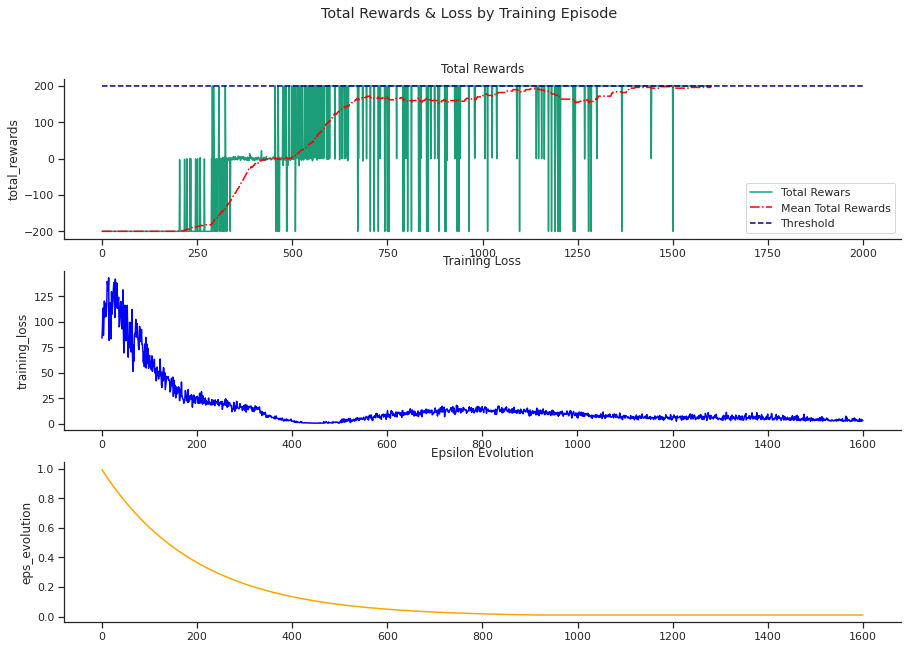

 80%|████████  | 1600/2000 [40:15<10:03,  1.51s/it]


In [ ]:
best_models_data = find_best_agent( L_BATCH_SIZE, L_LR, L_GAMMA, FIRST_CSV_NAME )

#### Elección mejor modelo 

In [ ]:
best_models_data.sort_values(by='solved_episode')

,agent_name,batch_size,lr,gamma,reward_mean,reward_std,training_time,solved_episode
8,9_DQN_Agent,128,0.0005,0.99,4.533190,172.469400,17.20,599
0,1_DQN_Agent,32,0.0005,0.99,53.335016,173.351734,16.63,834
10,11_DQN_Agent,128,0.0002,0.99,64.920167,170.826992,26.76,1135
4,5_DQN_Agent,64,0.0005,0.99,80.215897,162.246338,25.60,1302
5,6_DQN_Agent,64,0.0003,0.99,78.654492,164.925037,28.53,1478
11,12_DQN_Agent,128,0.0001,0.99,81.150435,163.085680,40.25,1501
2,3_DQN_Agent,32,0.0002,0.99,56.797561,169.410304,33.69,1534
9,10_DQN_Agent,128,0.0003,0.99,107.982696,153.269677,31.67,1813
1,2_DQN_Agent,32,0.0003,0.99,104.088434,156.038595,29.64,99999
3,4_DQN_Agent,32,0.0001,0.99,-22.406172,117.928658,69.08,99999


El mejor agente es número 9, se ha resuelto en 599 episodios con 128 de batch size, learning rate 0.0005.

## 2.3) Ejercicio 2.3 (0.5 puntos)
Probar el agente entrenado en el entorno de prueba. Visualizar su comportamiento (a
través de gráficas de las métricas más oportunas).


In [ ]:
# Parámetros:
MEMORY_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64
TARGET_UPDATE = 4
EPSILON_DECAY = 0.995
NN_UNITS = int(128)
GAMMA = 0.99  
TAU = 1e-3 
LR = 5e-4
MAX_EPSILON =  1.0
MIN_EPSILON = 0.01
THRESHOLD = 200
SEED = 123     
THRESHOLD = 200
ISNOISY = False

# Train
N_EPISODES = 2000
CONSECUTIVE_EIPOSDES = 100


# Nuevos parámetros:
BATCH_SIZE = 128
LR = 0.0005

agentDQN_best_DQN_Simple = DQNAgent(ENV_NAME, 
        AGENT_NAME,
        MEMORY_SIZE,
        BATCH_SIZE,
        TARGET_UPDATE,
        EPSILON_DECAY,
        TAU,
        ISNOISY,
        NN_UNITS,
        GAMMA,
        LR,
        MAX_EPSILON,
        MIN_EPSILON,
        THRESHOLD,
        SEED
        )


print(f'[INFO]: Agent DQN Created for [{agentDQN_best_DQN_Simple.env_name}] enviroment.')
print(f'[INFO]: Buffer Size: [{agentDQN_best_DQN_Simple.memory_size}].') 
print(f'[INFO]: Batch Size: [{agentDQN_best_DQN_Simple.batch_size}], Network Update：[{agentDQN_best_DQN_Simple.target_update}].')
print(f'[INFO]: Tau: [{agentDQN_best_DQN_Simple.tau}] and lr: [{agentDQN_best_DQN_Simple.lr}]. ')


VIDEO_NAME="Best_simple_DQN_Agent"
AGENT_DIR_NAME = 'LunarLander-v2_Agent_9_DQN_Agent_Batch_Size_128_Gamma_0.99_Lr_0.0005.pth'
test(agentDQN_best_DQN_Simple, AGENT_DIR_NAME,  VIDEO_NAME)

[INFO]: Using: [cpu]
[INFO]: Agent DQN Created for [LunarLander-v2] enviroment.
[INFO]: Buffer Size: [100000].
[INFO]: Batch Size: [128], Network Update：[4].
[INFO]: Tau: [0.001] and lr: [0.0005]. 


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

[INFO]: Total Reward:  269.881706999308
[INFO]: Recording, saving and showing video:  269.881706999308


([269.881706999308], [269.881706999308], [214])

## C) Propuesta de Mejora <a name="id6"></a>

En esta parte se pide implementar otro agente, entre aquellos que hemos visto a lo
largo de la asignatura, que pueda solucionar el problema de robótica espacial de forma
más eficiente con respecto al agente DQN

## 3.1) Ejercicio 3.1 (2 puntos)
Implementar el agente identificado en el entorno lunar-lander.
Justificar las razones que han llevado a probar este tipo de agente. Detallar qué tipos
de problemas se espera se puedan solucionar con respecto a la implementación DQN
anterior.




*Ver memoria de la actividad para conocer cuál ha sido el criterio de elección de los posibles modelos*



In [ ]:
# CONFIG First Agent

# Create Agent
ENV_NAME = "LunarLander-v2"
AGENT_NAME = 'DQN_agent'
MEMORY_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64
TARGET_UPDATE = 4
EPSILON_DECAY = 0.995
NN_UNITS = int(128)
GAMMA = 0.99 
TAU = 1e-3 
ISNOISY = True
LR = 5e-4
MAX_EPSILON =  1.0
MIN_EPSILON = 0.01
THRESHOLD = 200
SEED = 123     
THRESHOLD = 200

# Train
N_EPISODES = 2000
CONSECUTIVE_EIPOSDES = 100

### DQN Agent

In [ ]:
agentDQN_Noisy_Dueling = DQNAgent(ENV_NAME, 
        AGENT_NAME,
        MEMORY_SIZE,
        BATCH_SIZE,
        TARGET_UPDATE,
        EPSILON_DECAY,
        TAU,
        ISNOISY,
        NN_UNITS,
        GAMMA,
        LR,
        MAX_EPSILON,
        MIN_EPSILON,
        THRESHOLD,
        SEED
        )


print(f'[INFO]: Agent DQN Created for [{agentDQN_Noisy_Dueling .env_name}] enviroment.')
print(f'[INFO]: Buffer Size: [{agentDQN_Noisy_Dueling .memory_size}].') 
print(f'[INFO]: Batch Size: [{agentDQN_Noisy_Dueling .batch_size}], Network Update：[{agentDQN_Noisy_Dueling .target_update}].')
print(f'[INFO]: Tau: [{agentDQN_Noisy_Dueling.tau}] and lr: [{agentDQN_Noisy_Dueling.lr}]. ')

[INFO]: Using: [cpu]
[INFO]: Agent DQN Created for [LunarLander-v2] enviroment.
[INFO]: Buffer Size: [100000].
[INFO]: Batch Size: [64], Network Update：[4].
[INFO]: Tau: [0.001] and lr: [0.0005]. 


**Atención**. Como la red neuronal tiene el mismo nombre que la anterior deberemos ejecutar la red neuronal correspondiente a este caso. 

##  3.2) Ejercicio 3.2 (2 puntos)

Como hemos descrito en la memoria de la actividad el modelo que mejor ha funcionado para este entorno ha sido la combinación entre un red neuronal Dueling y Noisy


### Entrenamiento inicial


[TRAINING]: -------------------- Training Agent: DQN_agent--------------------



  5%|▌         | 100/2000 [00:34<15:01,  2.11it/s]

  [INFO]: Episode 100	Average reward: -200.00


 10%|█         | 200/2000 [03:13<1:36:39,  3.22s/it]

  [INFO]: Episode 200	Average reward: -155.45


 15%|█▌        | 300/2000 [09:38<1:49:59,  3.88s/it]

  [INFO]: Episode 300	Average reward: -21.96


 20%|██        | 400/2000 [14:38<40:38,  1.52s/it]

  [INFO]: Episode 400	Average reward: 57.85


 25%|██▌       | 500/2000 [17:53<41:40,  1.67s/it]

  [INFO]: Episode 500	Average reward: 92.15


 30%|███       | 600/2000 [20:27<21:56,  1.06it/s]

  [INFO]: Episode 600	Average reward: 152.03


 35%|███▌      | 700/2000 [22:30<31:18,  1.44s/it]

  [INFO]: Episode 700	Average reward: 170.03


 40%|████      | 800/2000 [24:19<22:54,  1.15s/it]

  [INFO]: Episode 800	Average reward: 186.04


 45%|████▌     | 900/2000 [25:56<17:24,  1.05it/s]

  [INFO]: Episode 900	Average reward: 177.98


 50%|█████     | 1000/2000 [27:38<16:09,  1.03it/s]

  [INFO]: Episode 1000	Average reward: 172.00


 55%|█████▌    | 1100/2000 [29:05<12:06,  1.24it/s]

  [INFO]: Episode 1100	Average reward: 160.00


 60%|██████    | 1200/2000 [30:45<12:35,  1.06it/s]

  [INFO]: Episode 1200	Average reward: 192.00


 65%|██████▌   | 1300/2000 [32:12<07:41,  1.52it/s]

  [INFO]: Episode 1300	Average reward: 190.00


 70%|███████   | 1400/2000 [33:39<07:05,  1.41it/s]

  [INFO]: Episode 1400	Average reward: 194.00


 75%|███████▌  | 1500/2000 [35:06<08:04,  1.03it/s]

  [INFO]: Episode 1500	Average reward: 174.00


 80%|████████  | 1600/2000 [36:28<07:12,  1.08s/it]

  [INFO]: Episode 1600	Average reward: 152.00


 85%|████████▌ | 1700/2000 [37:46<03:57,  1.26it/s]

  [INFO]: Episode 1700	Average reward: 184.00


 90%|█████████ | 1800/2000 [39:02<02:12,  1.51it/s]

  [INFO]: Episode 1800	Average reward: 184.00


 95%|█████████▌| 1900/2000 [40:30<01:06,  1.50it/s]

  [INFO]: Episode 1900	Average reward: 182.00


100%|█████████▉| 1999/2000 [41:56<00:00,  1.31it/s]

  [INFO]: Episode 2000	Average reward: 192.00


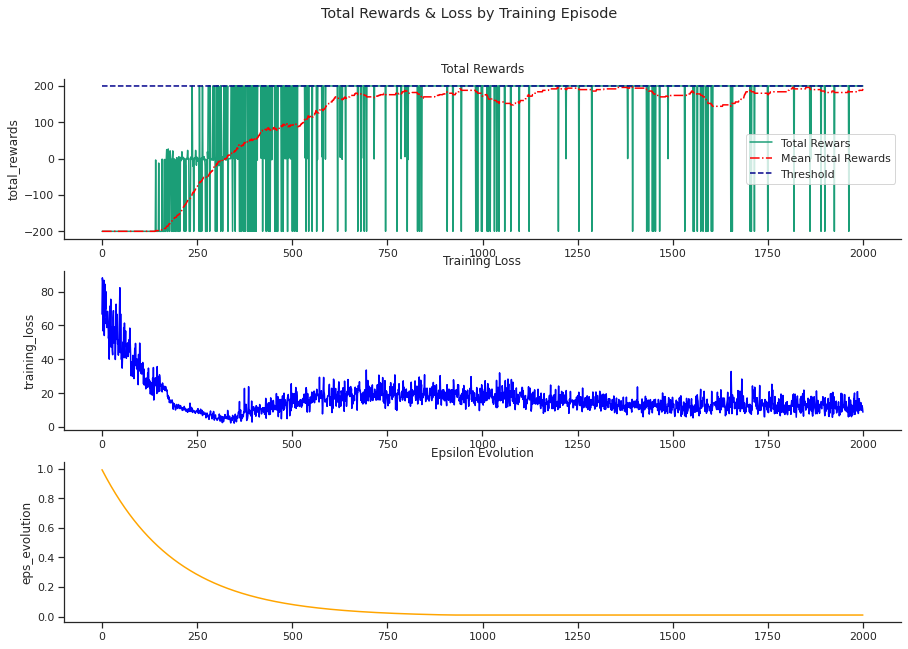

100%|██████████| 2000/2000 [41:59<00:00,  1.26s/it]


  [INFO]:  Environment has not been solved


In [ ]:
Noisy_Dueling_Reward_mean, Noisy_Dueling_training_time, Noisy_Dueling_solved_episode =  agentDQN_Noisy_Dueling.train(N_EPISODES)

In [ ]:
print(f'[INFO]: First Agent Metrics: Reward_Mean {Noisy_Dueling_Reward_mean}')
print(f'[INFO]: Training Time {Noisy_Dueling_training_time} min, Resolved episode {Noisy_Dueling_solved_episode}')

[INFO]: First Agent Metrics: Reward_Mean 121.73296696087209
[INFO]: Training Time 42.0 min, Resolved episode 99999


### Búsqueda de Hiperparámetros

Solo llevaremos a cabo 1000 iteraciones ya que nuestro objetivo será superar los modelos anteriores.

In [ ]:
L_BATCH_SIZE = [32, 64, 128]         # minibatch size
L_GAMMA = [0.99]            # Reducir el factor de descuento no funciona
L_LR = [5e-4,4e-4,3e-4]  # learning rate 
NN_UNITS = 128       
EPISODES = 1000 
     
FIRST_CSV_NAME = 'DQN_Noisy_Dueling_Best_models.csv'

[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 1 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0005]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 1_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:28<05:43,  2.62it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [01:54<21:52,  1.64s/it]

  [INFO]: Episode 200	Average reward: -188.08


 30%|███       | 300/1000 [07:49<46:25,  3.98s/it]

  [INFO]: Episode 300	Average reward: -31.61


 40%|████      | 400/1000 [12:54<21:16,  2.13s/it]

  [INFO]: Episode 400	Average reward: 93.76


 50%|█████     | 500/1000 [16:04<15:23,  1.85s/it]

  [INFO]: Episode 500	Average reward: 171.97


 60%|██████    | 600/1000 [18:14<08:15,  1.24s/it]

  [INFO]: Episode 600	Average reward: 190.00


 70%|███████   | 700/1000 [20:21<06:57,  1.39s/it]

  [INFO]: Episode 700	Average reward: 188.01


 80%|████████  | 800/1000 [22:29<05:01,  1.51s/it]

  [INFO]: Episode 800	Average reward: 142.10


 90%|█████████ | 900/1000 [24:20<01:34,  1.06it/s]

  [INFO]: Episode 900	Average reward: 153.97


100%|█████████▉| 999/1000 [26:07<00:00,  1.10it/s]

  [INFO]: Episode 1000	Average reward: 147.91


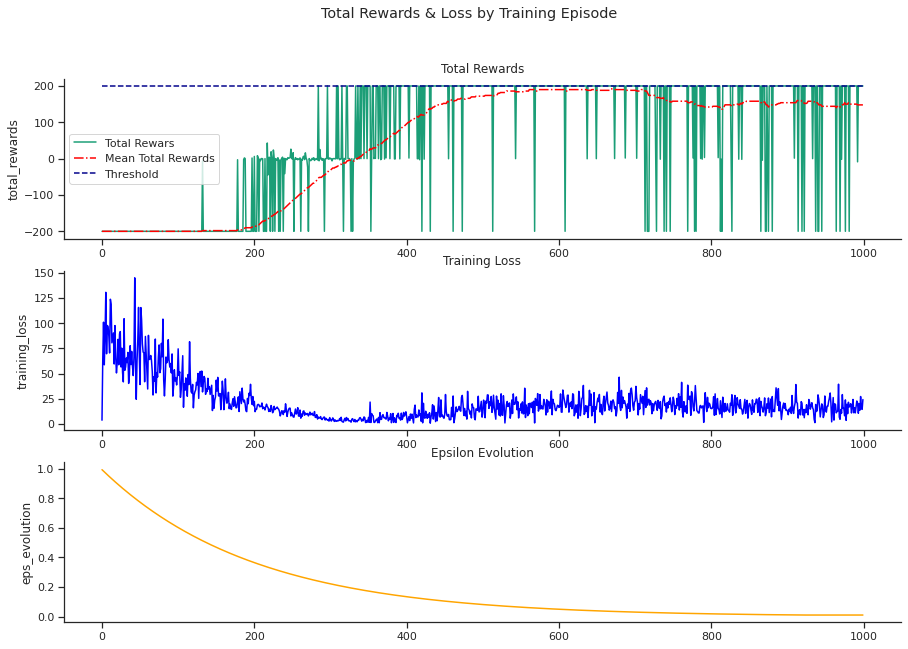

100%|██████████| 1000/1000 [26:09<00:00,  1.57s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 2 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0004]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 2_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:29<05:38,  2.66it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [02:19<12:54,  1.03it/s]

  [INFO]: Episode 200	Average reward: -170.25


 30%|███       | 300/1000 [08:04<44:55,  3.85s/it]

  [INFO]: Episode 300	Average reward: -13.02


 40%|████      | 400/1000 [12:34<27:18,  2.73s/it]

  [INFO]: Episode 400	Average reward: 95.60


 50%|█████     | 500/1000 [16:16<13:41,  1.64s/it]

  [INFO]: Episode 500	Average reward: 184.00


 60%|██████    | 600/1000 [18:49<08:45,  1.31s/it]

  [INFO]: Episode 600	Average reward: 169.93


 70%|███████   | 700/1000 [20:43<05:23,  1.08s/it]

  [INFO]: Episode 700	Average reward: 196.00


 80%|████████  | 800/1000 [22:27<02:58,  1.12it/s]

  [INFO]: Episode 800	Average reward: 185.98


 90%|█████████ | 900/1000 [24:06<01:25,  1.17it/s]

  [INFO]: Episode 900	Average reward: 188.00


100%|█████████▉| 999/1000 [25:42<00:00,  1.24it/s]

  [INFO]: Episode 1000	Average reward: 154.00


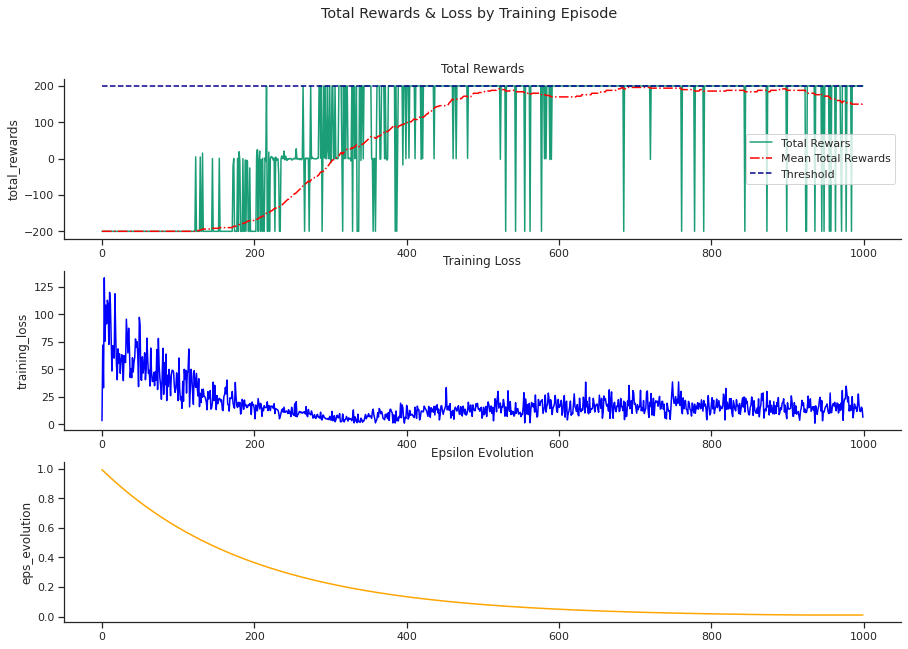

100%|██████████| 1000/1000 [25:44<00:00,  1.54s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 3 Hyperparameters --------------------

[INFO]: Batch Size: [32
[INFO]: Learning Rate: [0.0003]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 3_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:30<08:00,  1.87it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [01:38<30:17,  2.27s/it]

  [INFO]: Episode 200	Average reward: -189.24


 30%|███       | 300/1000 [07:22<44:15,  3.79s/it]

  [INFO]: Episode 300	Average reward: -58.34


 40%|████      | 400/1000 [13:19<35:23,  3.54s/it]

  [INFO]: Episode 400	Average reward: 15.29


 50%|█████     | 500/1000 [17:55<10:30,  1.26s/it]

  [INFO]: Episode 500	Average reward: 138.37


 60%|██████    | 600/1000 [20:06<07:02,  1.06s/it]

  [INFO]: Episode 600	Average reward: 195.98


 64%|██████▎   | 635/1000 [20:44<07:21,  1.21s/it]


  [INFO]:  Environment has been solved in 536 episodes!	Average reward: 200.00

[SAVING]: -------------------- Saving Agents--------------------



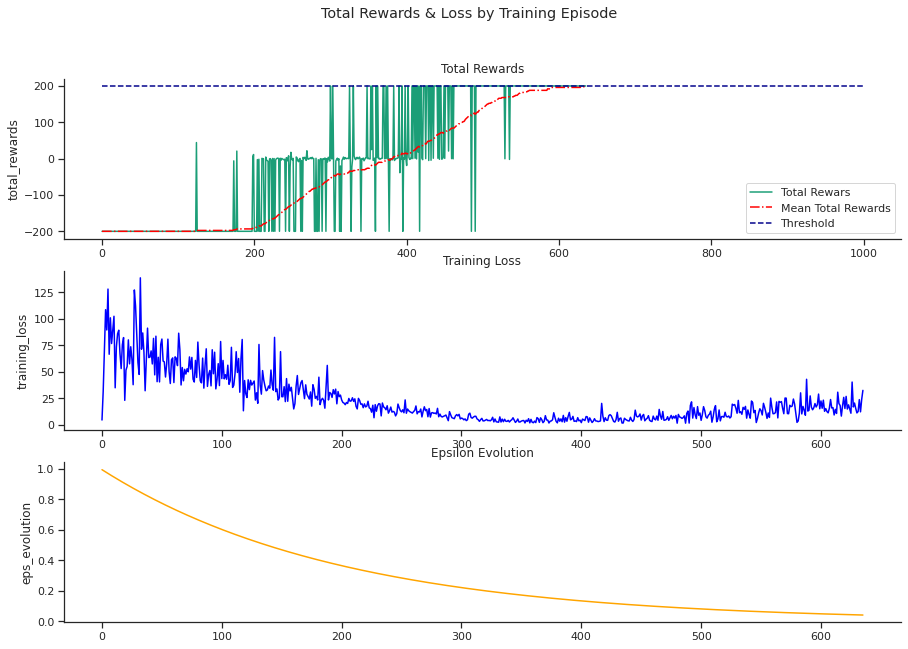

 64%|██████▎   | 635/1000 [20:46<11:56,  1.96s/it]


[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 4 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0005]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 4_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:33<05:45,  2.60it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [01:53<37:49,  2.84s/it]

  [INFO]: Episode 200	Average reward: -192.11


 30%|███       | 300/1000 [07:41<42:21,  3.63s/it]

  [INFO]: Episode 300	Average reward: -46.77


 40%|████      | 400/1000 [13:46<20:39,  2.07s/it]

  [INFO]: Episode 400	Average reward: 20.35


 50%|█████     | 500/1000 [17:14<12:46,  1.53s/it]

  [INFO]: Episode 500	Average reward: 140.19


 60%|██████    | 600/1000 [19:32<08:03,  1.21s/it]

  [INFO]: Episode 600	Average reward: 154.00


 70%|███████   | 700/1000 [21:19<05:27,  1.09s/it]

  [INFO]: Episode 700	Average reward: 176.00


 80%|████████  | 800/1000 [23:07<06:21,  1.91s/it]

  [INFO]: Episode 800	Average reward: 184.00


 90%|█████████ | 900/1000 [24:58<02:05,  1.25s/it]

  [INFO]: Episode 900	Average reward: 174.01


100%|█████████▉| 999/1000 [26:54<00:01,  1.27s/it]

  [INFO]: Episode 1000	Average reward: 161.99


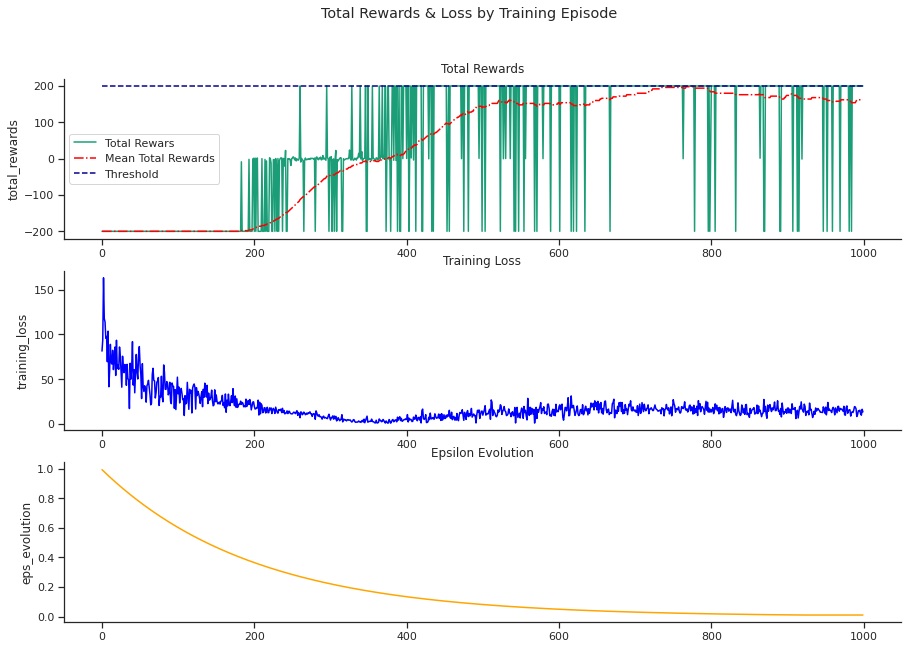

100%|██████████| 1000/1000 [26:57<00:00,  1.62s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 5 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0004]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 5_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:31<05:47,  2.59it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [02:08<22:03,  1.65s/it]

  [INFO]: Episode 200	Average reward: -177.59


 30%|███       | 300/1000 [07:27<47:53,  4.11s/it]

  [INFO]: Episode 300	Average reward: -49.29


 40%|████      | 400/1000 [13:39<29:04,  2.91s/it]

  [INFO]: Episode 400	Average reward: 36.44


 50%|█████     | 500/1000 [17:00<12:01,  1.44s/it]

  [INFO]: Episode 500	Average reward: 162.50


 60%|██████    | 600/1000 [19:15<05:36,  1.19it/s]

  [INFO]: Episode 600	Average reward: 152.01


 70%|███████   | 700/1000 [21:05<05:15,  1.05s/it]

  [INFO]: Episode 700	Average reward: 157.98


 80%|████████  | 800/1000 [23:07<04:08,  1.24s/it]

  [INFO]: Episode 800	Average reward: 191.98


 90%|█████████ | 900/1000 [24:56<01:42,  1.02s/it]

  [INFO]: Episode 900	Average reward: 186.00


100%|█████████▉| 999/1000 [26:40<00:01,  1.01s/it]

  [INFO]: Episode 1000	Average reward: 181.93


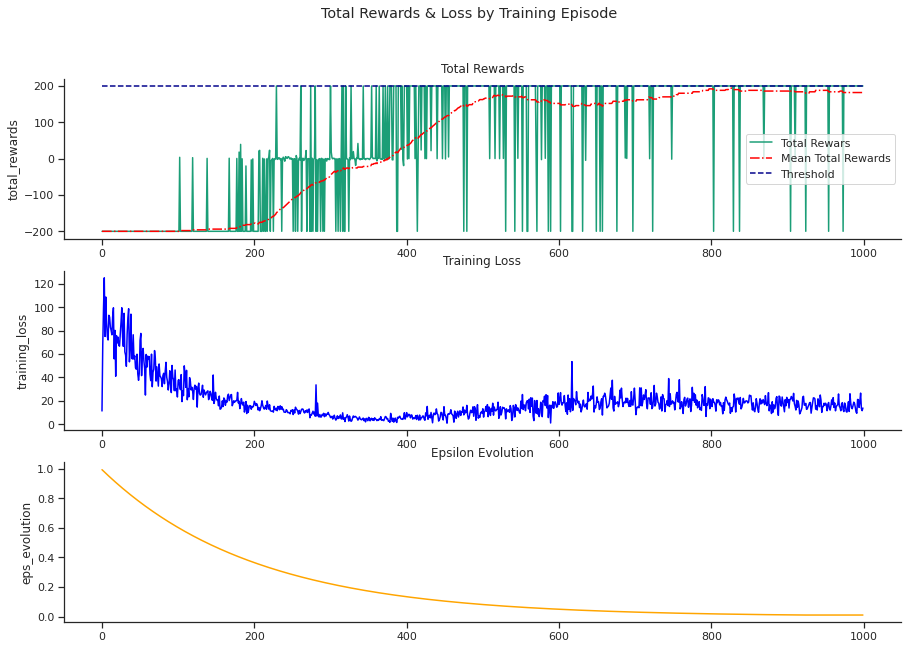

100%|██████████| 1000/1000 [26:42<00:00,  1.60s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 6 Hyperparameters --------------------

[INFO]: Batch Size: [64
[INFO]: Learning Rate: [0.0003]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 6_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:30<05:06,  2.94it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [01:48<15:43,  1.18s/it]

  [INFO]: Episode 200	Average reward: -188.29


 30%|███       | 300/1000 [07:11<44:55,  3.85s/it]

  [INFO]: Episode 300	Average reward: -68.91


 40%|████      | 400/1000 [13:26<37:59,  3.80s/it]

  [INFO]: Episode 400	Average reward: 16.59


 50%|█████     | 500/1000 [17:21<14:46,  1.77s/it]

  [INFO]: Episode 500	Average reward: 163.93


 60%|██████    | 600/1000 [20:09<08:55,  1.34s/it]

  [INFO]: Episode 600	Average reward: 175.99


 70%|███████   | 700/1000 [22:35<07:20,  1.47s/it]

  [INFO]: Episode 700	Average reward: 186.00


 80%|████████  | 800/1000 [24:39<02:13,  1.49it/s]

  [INFO]: Episode 800	Average reward: 136.02


 90%|█████████ | 900/1000 [26:31<03:46,  2.27s/it]

  [INFO]: Episode 900	Average reward: 185.99


100%|█████████▉| 999/1000 [28:18<00:00,  1.03it/s]

  [INFO]: Episode 1000	Average reward: 192.02


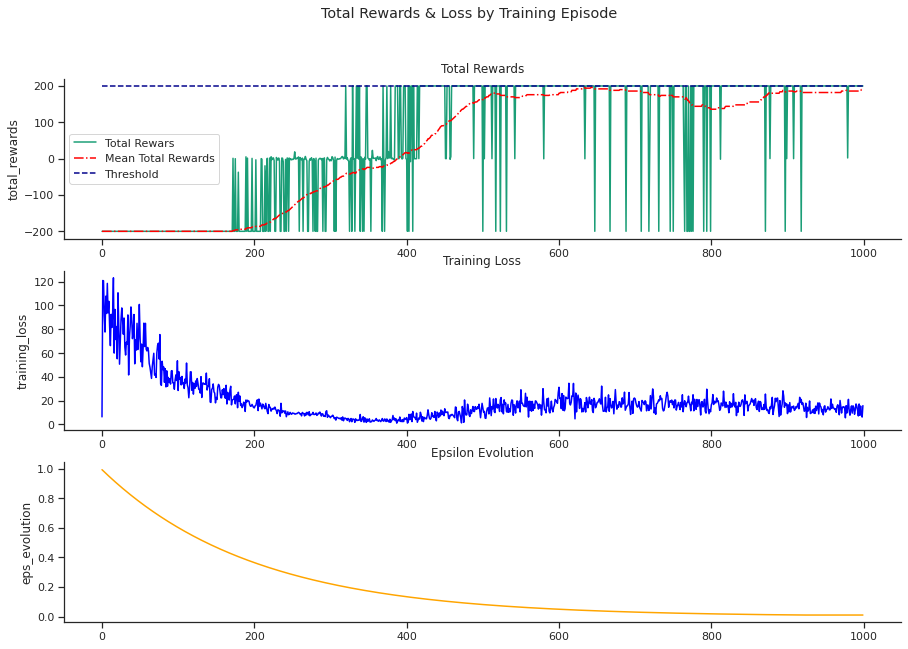

100%|██████████| 1000/1000 [28:20<00:00,  1.70s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 7 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0005]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 7_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:34<05:55,  2.53it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [02:22<37:28,  2.81s/it]

  [INFO]: Episode 200	Average reward: -181.39


 30%|███       | 300/1000 [08:03<44:06,  3.78s/it]

  [INFO]: Episode 300	Average reward: -62.68


 40%|████      | 400/1000 [12:53<27:50,  2.78s/it]

  [INFO]: Episode 400	Average reward: 106.04


 50%|█████     | 500/1000 [16:02<13:25,  1.61s/it]

  [INFO]: Episode 500	Average reward: 160.04


 60%|██████    | 600/1000 [19:04<07:52,  1.18s/it]

  [INFO]: Episode 600	Average reward: 161.96


 70%|███████   | 700/1000 [21:11<05:47,  1.16s/it]

  [INFO]: Episode 700	Average reward: 135.99


 80%|████████  | 800/1000 [23:21<03:33,  1.07s/it]

  [INFO]: Episode 800	Average reward: 163.96


 90%|█████████ | 900/1000 [25:14<01:21,  1.23it/s]

  [INFO]: Episode 900	Average reward: 184.00


100%|█████████▉| 999/1000 [26:54<00:00,  1.16it/s]

  [INFO]: Episode 1000	Average reward: 192.00


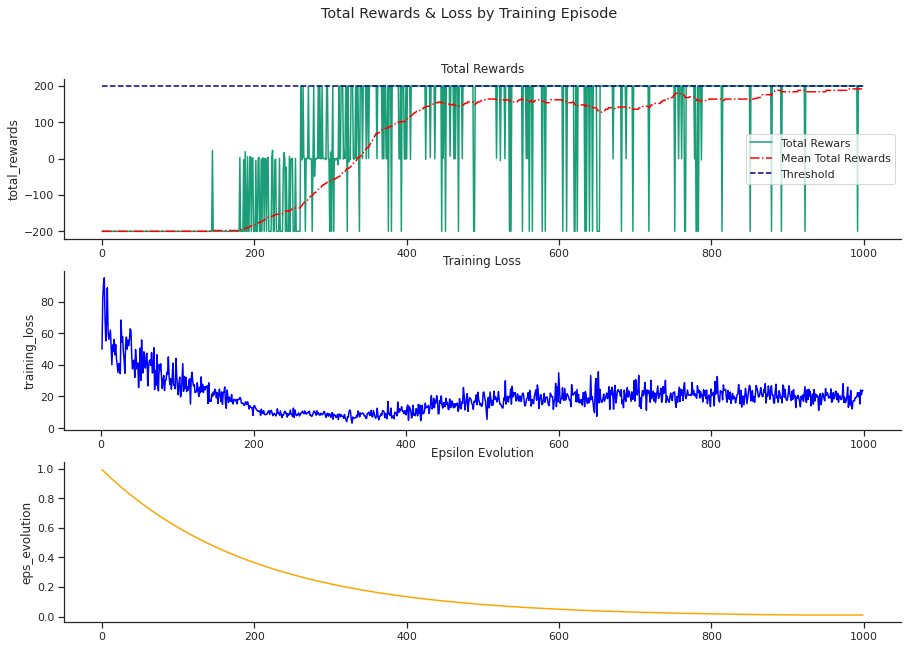

100%|██████████| 1000/1000 [26:56<00:00,  1.62s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 8 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0004]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 8_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:36<08:45,  1.71it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [02:14<35:17,  2.65s/it]

  [INFO]: Episode 200	Average reward: -186.10


 30%|███       | 300/1000 [08:32<45:39,  3.91s/it]

  [INFO]: Episode 300	Average reward: -40.79


 40%|████      | 400/1000 [14:48<27:07,  2.71s/it]

  [INFO]: Episode 400	Average reward: 87.89


 50%|█████     | 500/1000 [18:15<24:57,  2.99s/it]

  [INFO]: Episode 500	Average reward: 139.72


 60%|██████    | 600/1000 [21:27<13:03,  1.96s/it]

  [INFO]: Episode 600	Average reward: 176.06


 70%|███████   | 700/1000 [23:38<04:52,  1.03it/s]

  [INFO]: Episode 700	Average reward: 186.00


 80%|████████  | 800/1000 [25:45<03:52,  1.16s/it]

  [INFO]: Episode 800	Average reward: 180.00


 90%|█████████ | 900/1000 [27:32<01:21,  1.23it/s]

  [INFO]: Episode 900	Average reward: 152.01


100%|█████████▉| 999/1000 [28:57<00:00,  1.23it/s]

  [INFO]: Episode 1000	Average reward: 180.00


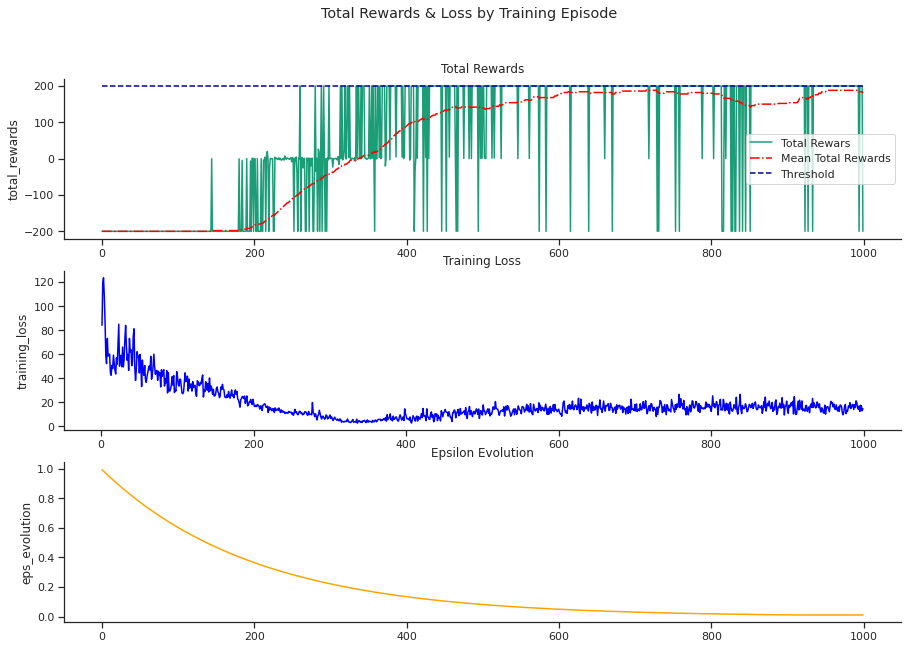

100%|██████████| 1000/1000 [28:58<00:00,  1.74s/it]



  [INFO]:  Environment has not been solved
[INFO]: Using: [cpu]

[INFO]: -------------------- AGENT 9 Hyperparameters --------------------

[INFO]: Batch Size: [128
[INFO]: Learning Rate: [0.0003]
[INFO]: Gamma: [0.99]


[TRAINING]: -------------------- Training Agent: 9_DDQN_Agent--------------------



 10%|█         | 100/1000 [00:36<06:45,  2.22it/s]

  [INFO]: Episode 100	Average reward: -200.00


 20%|██        | 200/1000 [02:52<23:37,  1.77s/it]

  [INFO]: Episode 200	Average reward: -165.56


 30%|███       | 300/1000 [09:46<40:37,  3.48s/it]

  [INFO]: Episode 300	Average reward: -26.57


 40%|████      | 400/1000 [15:34<32:48,  3.28s/it]

  [INFO]: Episode 400	Average reward: 58.75


 50%|█████     | 500/1000 [20:26<22:45,  2.73s/it]

  [INFO]: Episode 500	Average reward: 155.84


 60%|██████    | 600/1000 [23:02<10:50,  1.63s/it]

  [INFO]: Episode 600	Average reward: 169.92


 70%|███████   | 700/1000 [25:21<06:08,  1.23s/it]

  [INFO]: Episode 700	Average reward: 192.00


 80%|████████  | 800/1000 [27:13<03:04,  1.09it/s]

  [INFO]: Episode 800	Average reward: 196.00


 90%|█████████ | 900/1000 [29:08<02:02,  1.22s/it]

  [INFO]: Episode 900	Average reward: 184.05


100%|█████████▉| 999/1000 [31:03<00:01,  1.13s/it]

  [INFO]: Episode 1000	Average reward: 180.00


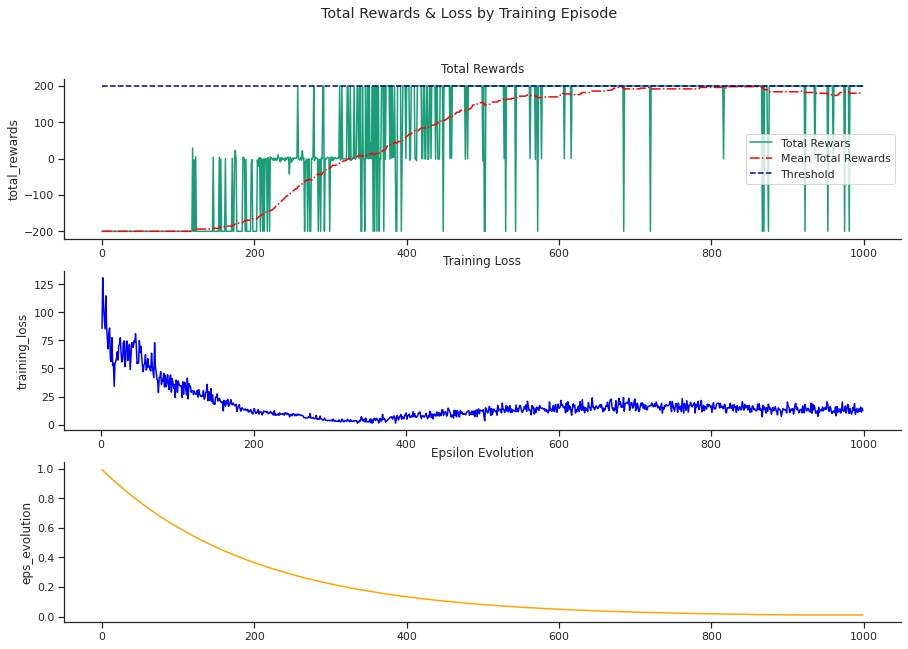

100%|██████████| 1000/1000 [31:05<00:00,  1.87s/it]


  [INFO]:  Environment has not been solved


In [ ]:
best_models_data = find_best_agent( L_BATCH_SIZE, L_LR, L_GAMMA, FIRST_CSV_NAME, True )

### Elección mejor modelo 

In [ ]:
best_models_data.sort_values(by='solved_episode')

,agent_name,batch_size,lr,gamma,reward_mean,reward_std,training_time,solved_episode
2,3_DDQN_Agent,32,0.0003,0.99,-4.080469,169.902372,20.78,536
0,1_DDQN_Agent,32,0.0005,0.99,66.803120,170.725828,26.16,99999
1,2_DDQN_Agent,32,0.0004,0.99,79.023623,168.175701,25.74,99999
3,4_DDQN_Agent,64,0.0005,0.99,57.167097,174.175008,26.96,99999
4,5_DDQN_Agent,64,0.0004,0.99,64.195556,170.554555,26.72,99999
5,6_DDQN_Agent,64,0.0003,0.99,59.933260,172.550969,28.35,99999
6,7_DDQN_Agent,128,0.0005,0.99,65.992992,176.330286,26.94,99999
7,8_DDQN_Agent,128,0.0004,0.99,67.477590,170.694480,28.97,99999
8,9_DDQN_Agent,128,0.0003,0.99,74.441499,165.610200,31.09,99999


El mejor agente es número 3, se ha resuelto en 536 episodios con 32 de batch size y learning rate 0.0003.


## 3.3) Ejercicio 3.3 (2 puntos)
Analizar el comportamiento del agente identificado entrenado en el entorno de prueba
y compararlo con el agente implementado en el punto 2 (a través de gráficas de las
métricas más oportunas).

### Comparación de los mejores Agentes

Seleccionamos el mejor modelo y comparamos los mejores modelos de cada apartado.

Inferencia del mejor modelo **DQN simple**, el video lo encontramos en el apartado 2.3 

Parámetros utilizados:

In [ ]:
# Parámetros:
MEMORY_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64
TARGET_UPDATE = 4
EPSILON_DECAY = 0.995
NN_UNITS = int(128)
GAMMA = 0.99  
TAU = 1e-3 
LR = 5e-4
MAX_EPSILON =  1.0
MIN_EPSILON = 0.01
THRESHOLD = 200
SEED = 123     
THRESHOLD = 200
ISNOISY = False

# Train
N_EPISODES = 2000
CONSECUTIVE_EIPOSDES = 100


# Nuevos parámetros:
BATCH_SIZE = 128
LR = 0.0005

agentDQN_best_DQN_Simple = DQNAgent(ENV_NAME, 
        AGENT_NAME,
        MEMORY_SIZE,
        BATCH_SIZE,
        TARGET_UPDATE,
        EPSILON_DECAY,
        TAU,
        ISNOISY,
        NN_UNITS,
        GAMMA,
        LR,
        MAX_EPSILON,
        MIN_EPSILON,
        THRESHOLD,
        SEED
        )


print(f'[INFO]: Agent DQN Created for [{agentDQN_best_DQN_Simple.env_name}] enviroment.')
print(f'[INFO]: Buffer Size: [{agentDQN_best_DQN_Simple.memory_size}].') 
print(f'[INFO]: Batch Size: [{agentDQN_best_DQN_Simple.batch_size}], Network Update：[{agentDQN_best_DQN_Simple.target_update}].')
print(f'[INFO]: Tau: [{agentDQN_best_DQN_Simple.tau}] and lr: [{agentDQN_best_DQN_Simple.lr}]. ')

[INFO]: Using: [cpu]
[INFO]: Agent DQN Created for [LunarLander-v2] enviroment.
[INFO]: Buffer Size: [100000].
[INFO]: Batch Size: [128], Network Update：[4].
[INFO]: Tau: [0.001] and lr: [0.0005]. 


In [ ]:
VIDEO_NAME=""
AGENT_DIR_NAME = 'LunarLander-v2_Agent_9_DQN_Agent_Batch_Size_128_Gamma_0.99_Lr_0.0005.pth'
EPISODES = 1000
best_simple_DQN_mean_testing_rewards, best_simple_DQN_total_rewards, best_simple_DQN_steps_episode = test(agentDQN_best_DQN_Simple,AGENT_DIR_NAME,  VIDEO_NAME, EPISODES, 1000, isVideo= False)

100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]

[INFO]: Total Reward Mean :  227.354628286933


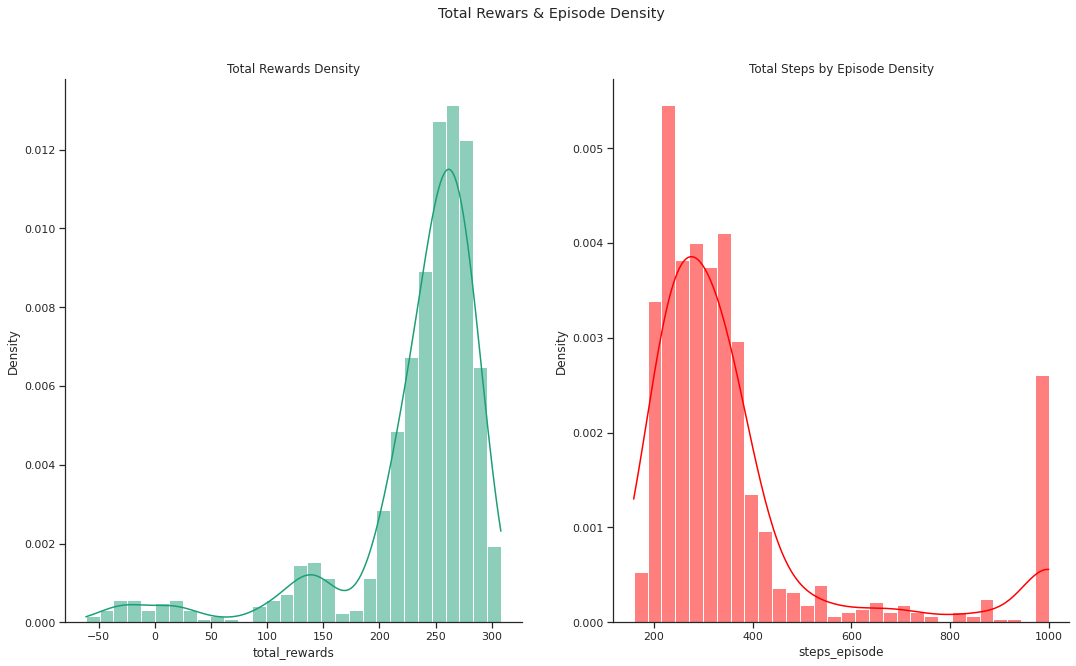

In [ ]:
plot_histograms('best_simple_DQN_agent', best_simple_DQN_total_rewards, best_simple_DQN_steps_episode )

Inferencia del mejor modelo **DQN Dueling + Noisy**

Parámetros utilizados:


*No olvidar cambiar la red neuronal según el modelo que estamos usando*

In [ ]:
# Parámetros:
MEMORY_SIZE = 100000  # replay buffer size
BATCH_SIZE = 64
TARGET_UPDATE = 4
EPSILON_DECAY = 0.995
NN_UNITS = int(128)
GAMMA = 0.99  
TAU = 1e-3 
LR = 5e-4
MAX_EPSILON =  1.0
MIN_EPSILON = 0.01
THRESHOLD = 200
SEED = 123     
THRESHOLD = 200
ISNOISY = True

# Train
N_EPISODES = 2000
CONSECUTIVE_EIPOSDES = 100


# Nuevos parámetros:
BATCH_SIZE = 32
LR = 0.0003

agentDQN_best_Noisy_Dueling = DQNAgent(ENV_NAME, 
        AGENT_NAME,
        MEMORY_SIZE,
        BATCH_SIZE,
        TARGET_UPDATE,
        EPSILON_DECAY,
        TAU,
        ISNOISY,
        NN_UNITS,
        GAMMA,
        LR,
        MAX_EPSILON,
        MIN_EPSILON,
        THRESHOLD,
        SEED
        )


print(f'[INFO]: Agent DQN Created for [{agentDQN_best_Noisy_Dueling.env_name}] enviroment.')
print(f'[INFO]: Buffer Size: [{agentDQN_best_Noisy_Dueling .memory_size}].') 
print(f'[INFO]: Batch Size: [{agentDQN_best_Noisy_Dueling .batch_size}], Network Update：[{agentDQN_best_Noisy_Dueling.target_update}].')
print(f'[INFO]: Tau: [{agentDQN_best_Noisy_Dueling.tau}] and lr: [{agentDQN_best_Noisy_Dueling.lr}]. ')

[INFO]: Using: [cpu]
[INFO]: Agent DQN Created for [LunarLander-v2] enviroment.
[INFO]: Buffer Size: [100000].
[INFO]: Batch Size: [32], Network Update：[4].
[INFO]: Tau: [0.001] and lr: [0.0003]. 


Video del modelo último modelo:

In [ ]:
VIDEO_NAME="best_final_DQN_Agent"
AGENT_DIR_NAME = 'LunarLander-v2_Agent_3_DDQN_Agent_Batch_Size_32_Gamma_0.99_Lr_0.0003.pth'
test(agentDQN_best_Noisy_Dueling, AGENT_DIR_NAME,  VIDEO_NAME)

[INFO]: Total Reward:  288.10974154657174
[INFO]: Recording, saving and showing video:  288.10974154657174


[288.10974154657174]

In [ ]:
VIDEO_NAME=""
AGENT_DIR_NAME = 'LunarLander-v2_Agent_3_DDQN_Agent_Batch_Size_32_Gamma_0.99_Lr_0.0003.pth'
EPISODES = 1000
best_dueling_noisy_mean_testing_rewards, best_dueling_noisy_total_rewards, best_dueling_noisy_steps_episode = test(agentDQN_best_Noisy_Dueling,AGENT_DIR_NAME,  VIDEO_NAME, EPISODES, 1000, isVideo= False)

100%|██████████| 1000/1000 [07:59<00:00,  2.09it/s]

[INFO]: Total Reward Mean :  241.97495695027908


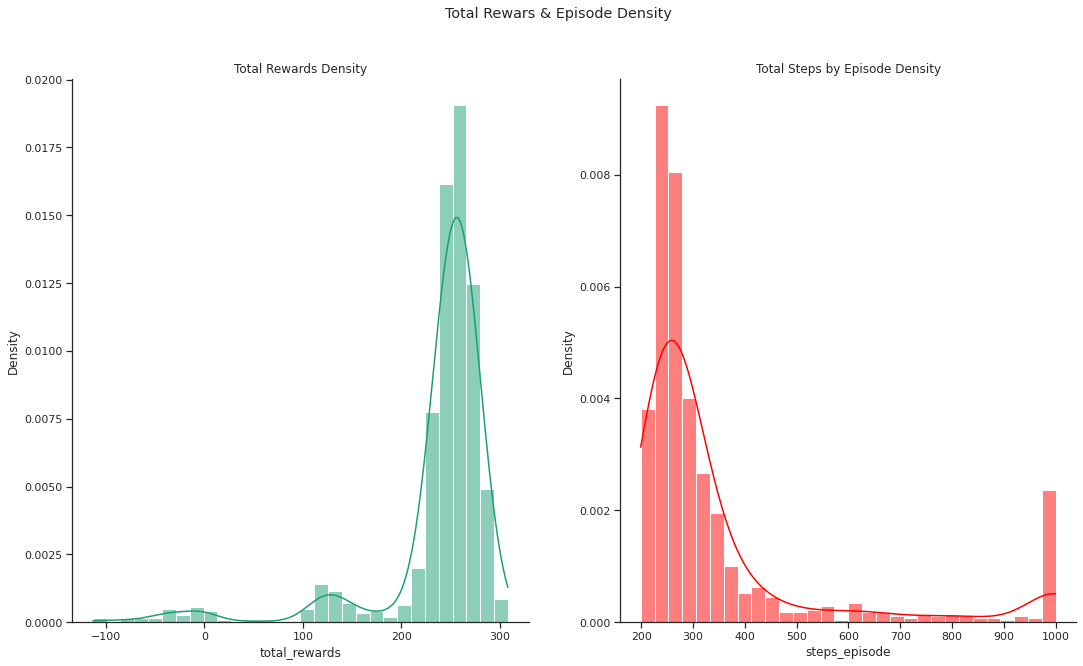

In [ ]:
plot_histograms('best_dueling_noisy_DQN_agent', best_dueling_noisy_total_rewards, best_dueling_noisy_steps_episode )

Comparaciones de modelos:

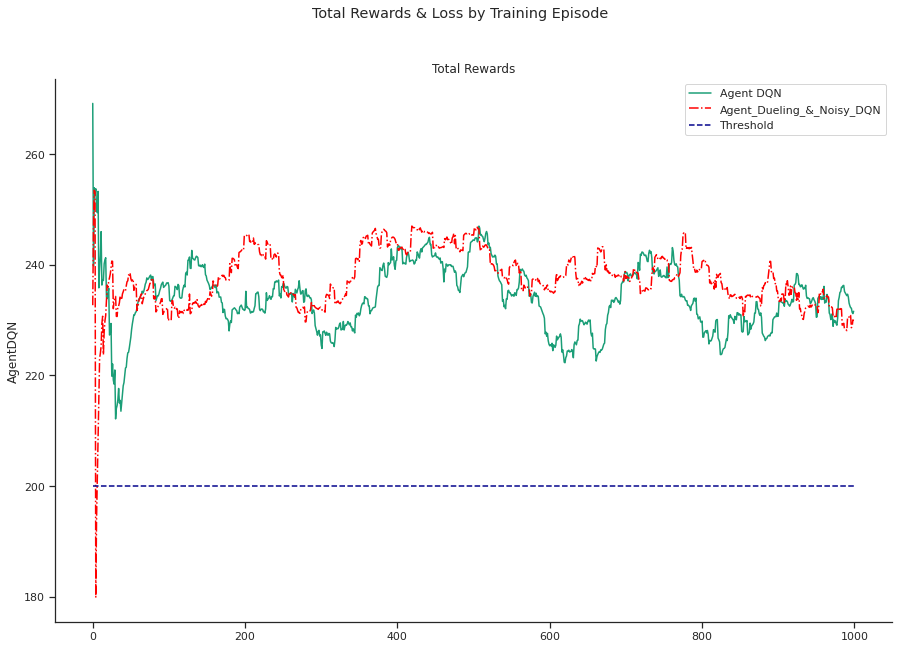

In [ ]:
EPISODES = 1000
THRESHOLD = 200
plot_compare_results(best_simple_DQN_mean_testing_rewards, best_dueling_noisy_mean_testing_rewards,
                        EPISODES, THRESHOLD)

In [ ]:
print(f'[INFO]: Best Simple DQN Inference Reward Mean: [{np.mean(best_simple_DQN_total_rewards)}].')
print(f'[INFO]: Best Dueling + Noisy DQN Inference Reward Mean: [{np.mean(best_dueling_noisy_total_rewards)}].') 
print(f'[INFO]: Best Simple DQN Inference Reward standard deviation : [{np.std(best_simple_DQN_total_rewards)}].')
print(f'[INFO]: Best Dueling + Noisy DQN Reward standard deviation  [{np.std(best_dueling_noisy_total_rewards)}].')

[INFO]: Best Simple DQN Inference Reward Mean: [233.7370009796463].
[INFO]: Best Dueling + Noisy DQN Inference Reward Mean: [237.5079157191881].
[INFO]: Best Simple DQN Inference Reward standard deviation : [65.60475366732524].
[INFO]: Best Dueling + Noisy DQN Reward standard deviation  [61.953035934243346].


Si observamos ambos videos podemos comprobar que para el último modelo la puntuación es mayor debido a que la nave usará menos energia para aterrizar. Más información en la memoria de la actividad. 


Podemos comprobar que el modelo Noisy + DQN es ligeramente mejor que el DQN Simple

Para una comparación más entensa de ambos agentes leer la memoria del proyecto.

## Referencias

Busqueda de Hiperparámetros:

[[1 Enlace]](https://towardsdatascience.com/hyperparameters-in-deep-rl-f8a9cf264cd6)


GymLibrary:

[[1. Enlace]](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)  [[2. Enlace]](https://github.com/pythonlessons/Reinforcement_Learning/blob/master/LunarLander-v2_PPO/LunarLander-v2_PPO.py)


DQN & Dueling DQN:

[[1. Enlace]](https://github.com/jcasasr/Aprendizaje-por-refuerzo/blob/main/M09/M09-E1-%20Ejemplo%20DQN%20en%20CartPole%20(PID_00284557)%20%5Bes%5D.ipynb)   [[2. Enlace]](https://arxiv.org/abs/1511.06581) [[3. Enlace]](https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751)
 [[4. Enlace]](https://github.com/dxyang/DQN_pytorch) [[5. Enlace]](https://github.com/lychengrex/Playing-Space-Invaders-with-Deep-Q-Networks) [[6. Enlace]](https://wandb.ai/raghmura/qualcomm/reports/Space-Invaders-challenge-a-Reinforcement-Learning-competition--Vmlldzo5MzEzMg) [[7. Enlace]](https://towardsdatascience.com/techniques-to-improve-the-performance-of-a-dqn-agent-29da8a7a0a7e)


Video & Buffer

[[1. Enlace]](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html)

Noisy Layer

[[1. Enlace]](https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb) [[2. Enlace]](https://github.com/Kaixhin/Rainbow/blob/master/model.py)

PPO 

[[1. Enlace]](https://openai.com/blog/openai-baselines-ppo/) [[2. Enlace]](https://ieeexplore.ieee.org/document/9501950) [[3. Enlace]](https://cse.buffalo.edu/~avereshc/rl_fall20/Comparison_of_RL_Algorithms_vvelivel_sudhirya.pdf)

AC3 


[[1. Enlace]](https://pylessons.com/A3C-reinforcement-learning) [[2. Enlace]](https://github.com/nikhilbarhate99/Actor-Critic-PyTorch) [[3. Enlace]](https://xusophia.github.io/DataSciFinalProj/)

Rainbow 

[[1. Enlace]](https://github.com/Curt-Park/rainbow-is-all-you-need)
